In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

from utilsfc import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100))

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        self.label_emb = nn.Embedding(10, 10)
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, labels):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out
    

In [7]:
G = FullyConnected([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+10, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [10]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
        fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
        fake_pred = D(G(z, fake_labels), fake_labels)
        true_pred = D(data, target)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        #fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
        fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))
        fake_pred = D(G(z, fake_labels), fake_labels)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [11]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, target), target)
            true_pred = D(data, target)
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z, target).data.numpy().reshape(50, 1, 28, 28)
    print('target:', target)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.6878, D: 0.6996
Train Epoch: 1 [5000/50000 (10%)]	Losses G: 1.5112, D: 0.2636
Train Epoch: 1 [10000/50000 (20%)]	Losses G: 2.3098, D: 0.1864
Train Epoch: 1 [15000/50000 (30%)]	Losses G: 1.9869, D: 0.4552
Train Epoch: 1 [20000/50000 (40%)]	Losses G: 3.6652, D: 0.0749
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.8969, D: 0.4271
Train Epoch: 1 [30000/50000 (60%)]	Losses G: 1.8930, D: 0.2153
Train Epoch: 1 [35000/50000 (70%)]	Losses G: 0.9747, D: 0.6977
Train Epoch: 1 [40000/50000 (80%)]	Losses G: 4.0133, D: 0.2017
Train Epoch: 1 [45000/50000 (90%)]	Losses G: 1.5506, D: 0.3610
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 4.7035, D: 0.1431
target: tensor([0, 3, 0, 8, 4, 1, 6, 7, 9, 8, 2, 5, 7, 2, 0, 9, 3, 1, 7, 2, 8, 2, 7, 2,
        9, 8, 5, 2, 1, 6, 4, 9, 3, 2, 8, 7, 3, 6, 2, 4, 1, 7, 2, 8, 9, 4, 3, 5,
        6, 6])


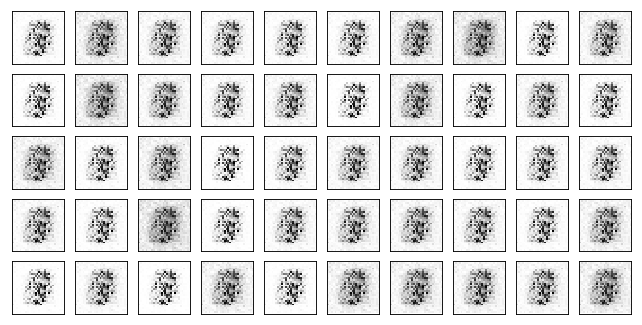

Test losses. G: 3.3819, D: 0.0962
Train Epoch: 2 [0/50000 (0%)]	Losses G: 4.5539, D: 0.2521
Train Epoch: 2 [5000/50000 (10%)]	Losses G: 0.5087, D: 0.8524
Train Epoch: 2 [10000/50000 (20%)]	Losses G: 1.7393, D: 0.4047
Train Epoch: 2 [15000/50000 (30%)]	Losses G: 1.3966, D: 0.5741
Train Epoch: 2 [20000/50000 (40%)]	Losses G: 0.9264, D: 0.7371
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.4579, D: 0.4826
Train Epoch: 2 [30000/50000 (60%)]	Losses G: 2.5293, D: 0.1353
Train Epoch: 2 [35000/50000 (70%)]	Losses G: 4.4676, D: 0.1903
Train Epoch: 2 [40000/50000 (80%)]	Losses G: 3.7170, D: 0.1493
Train Epoch: 2 [45000/50000 (90%)]	Losses G: 2.8877, D: 0.1280
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 3.3494, D: 0.1127
target: tensor([4, 9, 4, 6, 9, 1, 0, 5, 7, 5, 5, 2, 8, 1, 7, 7, 0, 9, 4, 4, 7, 7, 2, 5,
        0, 2, 1, 6, 6, 6, 9, 1, 7, 9, 8, 6, 8, 0, 3, 2, 1, 5, 5, 6, 9, 1, 5, 6,
        0, 3])


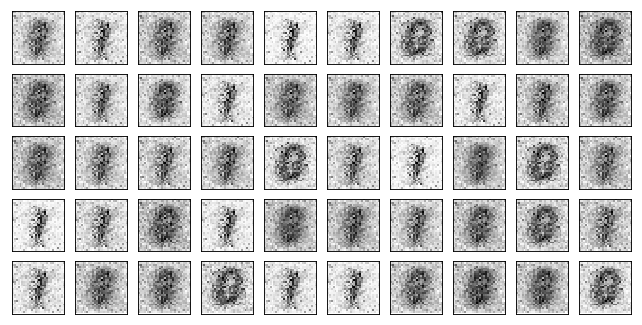

Test losses. G: 3.1304, D: 0.0412
Train Epoch: 3 [0/50000 (0%)]	Losses G: 3.3313, D: 0.1013
Train Epoch: 3 [5000/50000 (10%)]	Losses G: 4.8167, D: 0.0781
Train Epoch: 3 [10000/50000 (20%)]	Losses G: 3.7928, D: 0.1915
Train Epoch: 3 [15000/50000 (30%)]	Losses G: 4.7531, D: 0.1276
Train Epoch: 3 [20000/50000 (40%)]	Losses G: 3.8951, D: 0.2287
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 4.8282, D: 0.1960
Train Epoch: 3 [30000/50000 (60%)]	Losses G: 4.6130, D: 0.1631
Train Epoch: 3 [35000/50000 (70%)]	Losses G: 3.2211, D: 0.1277
Train Epoch: 3 [40000/50000 (80%)]	Losses G: 4.3287, D: 0.0313
Train Epoch: 3 [45000/50000 (90%)]	Losses G: 3.8901, D: 0.1893
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 2.5776, D: 0.2951
target: tensor([1, 5, 1, 5, 1, 5, 5, 5, 8, 3, 2, 6, 4, 5, 5, 0, 4, 5, 5, 9, 3, 5, 9, 2,
        7, 5, 2, 1, 3, 9, 1, 3, 6, 2, 8, 9, 2, 2, 5, 9, 1, 1, 5, 2, 2, 7, 2, 7,
        4, 1])


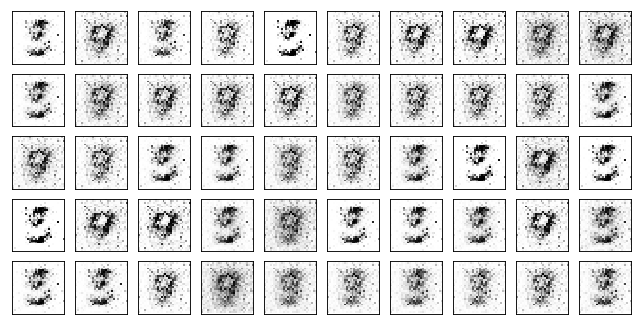

Test losses. G: 1.8901, D: 0.1371
Train Epoch: 4 [0/50000 (0%)]	Losses G: 2.1825, D: 0.2231
Train Epoch: 4 [5000/50000 (10%)]	Losses G: 4.9044, D: 0.1406
Train Epoch: 4 [10000/50000 (20%)]	Losses G: 5.7452, D: 0.1768
Train Epoch: 4 [15000/50000 (30%)]	Losses G: 3.8046, D: 0.1132
Train Epoch: 4 [20000/50000 (40%)]	Losses G: 4.4093, D: 0.0708
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 4.0097, D: 0.2579
Train Epoch: 4 [30000/50000 (60%)]	Losses G: 4.1440, D: 0.1491
Train Epoch: 4 [35000/50000 (70%)]	Losses G: 5.5393, D: 0.0936
Train Epoch: 4 [40000/50000 (80%)]	Losses G: 3.7375, D: 0.1083
Train Epoch: 4 [45000/50000 (90%)]	Losses G: 4.8228, D: 0.2233
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 4.6152, D: 0.1661
target: tensor([3, 3, 7, 3, 8, 4, 4, 9, 6, 4, 1, 8, 2, 9, 9, 3, 5, 5, 1, 1, 6, 1, 5, 6,
        9, 4, 3, 1, 1, 5, 8, 9, 8, 2, 3, 3, 8, 9, 2, 0, 6, 9, 5, 3, 2, 5, 3, 2,
        9, 5])


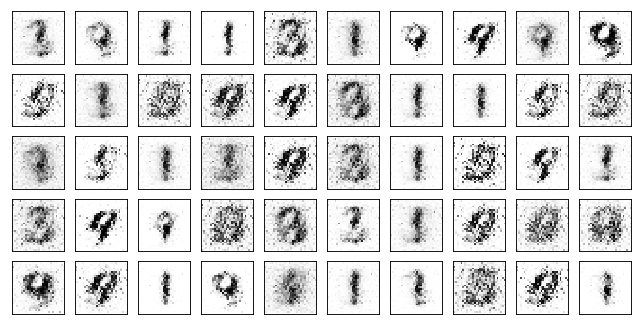

Test losses. G: 3.9476, D: 0.0922
Train Epoch: 5 [0/50000 (0%)]	Losses G: 4.5203, D: 0.1656
Train Epoch: 5 [5000/50000 (10%)]	Losses G: 4.5112, D: 0.1180
Train Epoch: 5 [10000/50000 (20%)]	Losses G: 5.2288, D: 0.1351
Train Epoch: 5 [15000/50000 (30%)]	Losses G: 4.9619, D: 0.1693
Train Epoch: 5 [20000/50000 (40%)]	Losses G: 3.7247, D: 0.1651
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 3.7831, D: 0.1158
Train Epoch: 5 [30000/50000 (60%)]	Losses G: 5.4549, D: 0.1385
Train Epoch: 5 [35000/50000 (70%)]	Losses G: 2.9299, D: 0.2047
Train Epoch: 5 [40000/50000 (80%)]	Losses G: 3.6912, D: 0.1927
Train Epoch: 5 [45000/50000 (90%)]	Losses G: 3.1181, D: 0.2240
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 3.8030, D: 0.1963
target: tensor([5, 6, 2, 0, 9, 8, 2, 6, 5, 0, 0, 2, 9, 7, 6, 5, 5, 2, 1, 7, 9, 6, 2, 8,
        5, 1, 8, 9, 6, 3, 9, 6, 4, 5, 7, 9, 6, 0, 1, 4, 8, 4, 1, 3, 6, 5, 7, 8,
        9, 3])


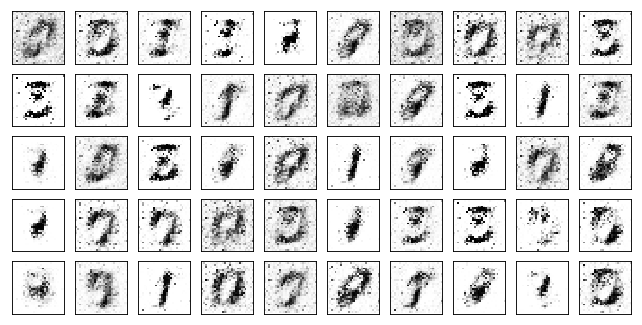

Test losses. G: 3.2230, D: 0.0569
Train Epoch: 6 [0/50000 (0%)]	Losses G: 3.1799, D: 0.1785
Train Epoch: 6 [5000/50000 (10%)]	Losses G: 5.1801, D: 0.1130
Train Epoch: 6 [10000/50000 (20%)]	Losses G: 3.2223, D: 0.1626
Train Epoch: 6 [15000/50000 (30%)]	Losses G: 4.8269, D: 0.3003
Train Epoch: 6 [20000/50000 (40%)]	Losses G: 3.8777, D: 0.1721
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 3.7471, D: 0.1612
Train Epoch: 6 [30000/50000 (60%)]	Losses G: 3.8279, D: 0.1437
Train Epoch: 6 [35000/50000 (70%)]	Losses G: 5.9601, D: 0.1794
Train Epoch: 6 [40000/50000 (80%)]	Losses G: 2.0986, D: 0.2959
Train Epoch: 6 [45000/50000 (90%)]	Losses G: 2.8130, D: 0.2190
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.0212, D: 0.2020
target: tensor([3, 2, 7, 7, 8, 7, 1, 8, 3, 7, 4, 3, 4, 7, 0, 5, 1, 3, 3, 7, 8, 6, 1, 0,
        9, 3, 7, 4, 1, 7, 8, 6, 3, 4, 4, 1, 0, 9, 1, 7, 0, 3, 6, 2, 8, 8, 4, 0,
        2, 8])


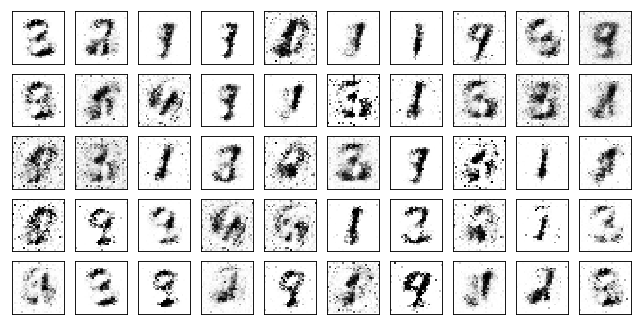

Test losses. G: 2.3838, D: 0.1343
Train Epoch: 7 [0/50000 (0%)]	Losses G: 2.8172, D: 0.3197
Train Epoch: 7 [5000/50000 (10%)]	Losses G: 3.5154, D: 0.2488
Train Epoch: 7 [10000/50000 (20%)]	Losses G: 4.0762, D: 0.1453
Train Epoch: 7 [15000/50000 (30%)]	Losses G: 2.8441, D: 0.3291
Train Epoch: 7 [20000/50000 (40%)]	Losses G: 2.9577, D: 0.2624
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.5934, D: 0.2478
Train Epoch: 7 [30000/50000 (60%)]	Losses G: 3.2095, D: 0.2218
Train Epoch: 7 [35000/50000 (70%)]	Losses G: 3.3351, D: 0.2026
Train Epoch: 7 [40000/50000 (80%)]	Losses G: 3.4248, D: 0.2242
Train Epoch: 7 [45000/50000 (90%)]	Losses G: 3.4658, D: 0.1307
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 2.9579, D: 0.2091
target: tensor([6, 2, 0, 4, 5, 8, 6, 1, 3, 8, 5, 7, 1, 4, 5, 8, 5, 7, 6, 0, 5, 4, 4, 9,
        2, 4, 4, 5, 1, 7, 6, 6, 7, 8, 3, 0, 5, 7, 2, 7, 9, 3, 9, 0, 6, 1, 0, 5,
        8, 6])


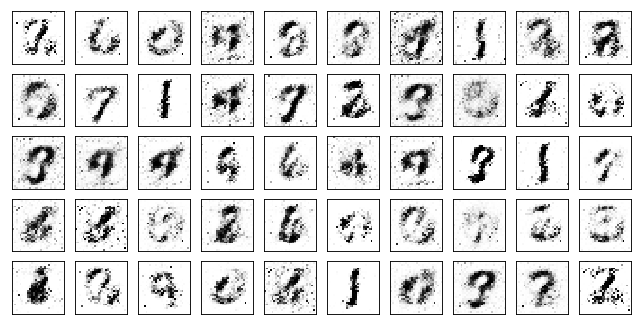

Test losses. G: 2.3917, D: 0.1128
Train Epoch: 8 [0/50000 (0%)]	Losses G: 3.1199, D: 0.1293
Train Epoch: 8 [5000/50000 (10%)]	Losses G: 3.0125, D: 0.1548
Train Epoch: 8 [10000/50000 (20%)]	Losses G: 3.4698, D: 0.1561
Train Epoch: 8 [15000/50000 (30%)]	Losses G: 4.3290, D: 0.0666
Train Epoch: 8 [20000/50000 (40%)]	Losses G: 3.7779, D: 0.2555
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 2.9270, D: 0.2219
Train Epoch: 8 [30000/50000 (60%)]	Losses G: 3.6297, D: 0.0997
Train Epoch: 8 [35000/50000 (70%)]	Losses G: 3.1356, D: 0.1790
Train Epoch: 8 [40000/50000 (80%)]	Losses G: 2.4381, D: 0.3128
Train Epoch: 8 [45000/50000 (90%)]	Losses G: 3.4703, D: 0.2244
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 3.4714, D: 0.2412
target: tensor([4, 4, 7, 0, 0, 1, 3, 8, 2, 7, 9, 2, 8, 9, 7, 7, 3, 5, 5, 7, 1, 7, 5, 1,
        1, 7, 7, 1, 9, 2, 0, 9, 9, 8, 1, 2, 6, 0, 3, 6, 3, 9, 9, 3, 8, 8, 0, 0,
        5, 1])


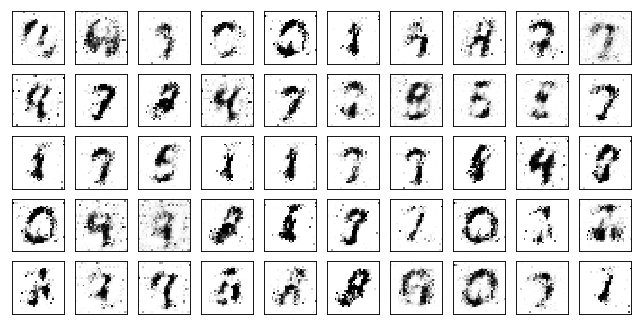

Test losses. G: 2.7666, D: 0.1158
Train Epoch: 9 [0/50000 (0%)]	Losses G: 2.7930, D: 0.4284
Train Epoch: 9 [5000/50000 (10%)]	Losses G: 4.1133, D: 0.1856
Train Epoch: 9 [10000/50000 (20%)]	Losses G: 3.4120, D: 0.1046
Train Epoch: 9 [15000/50000 (30%)]	Losses G: 4.1986, D: 0.1303
Train Epoch: 9 [20000/50000 (40%)]	Losses G: 3.0683, D: 0.1488
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 2.8356, D: 0.2644
Train Epoch: 9 [30000/50000 (60%)]	Losses G: 3.5200, D: 0.2863
Train Epoch: 9 [35000/50000 (70%)]	Losses G: 2.7791, D: 0.3191
Train Epoch: 9 [40000/50000 (80%)]	Losses G: 3.0239, D: 0.1775
Train Epoch: 9 [45000/50000 (90%)]	Losses G: 2.3532, D: 0.2629
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 2.6137, D: 0.3121
target: tensor([2, 8, 1, 9, 6, 4, 6, 3, 1, 6, 5, 3, 5, 9, 0, 5, 7, 7, 3, 8, 1, 8, 1, 6,
        6, 1, 7, 6, 5, 2, 7, 1, 1, 5, 2, 3, 0, 4, 3, 5, 1, 0, 3, 8, 5, 8, 1, 1,
        9, 4])


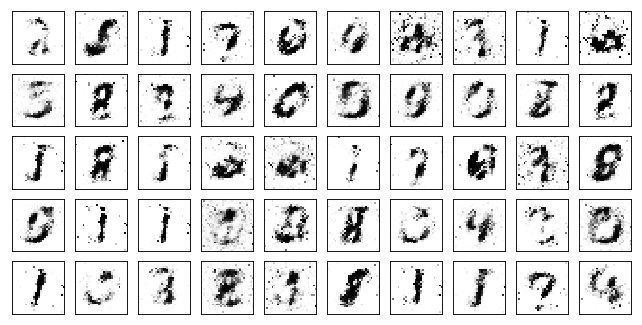

Test losses. G: 2.3405, D: 0.1677
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.7842, D: 0.3466
Train Epoch: 10 [5000/50000 (10%)]	Losses G: 2.5204, D: 0.2384
Train Epoch: 10 [10000/50000 (20%)]	Losses G: 3.1844, D: 0.2039
Train Epoch: 10 [15000/50000 (30%)]	Losses G: 2.3856, D: 0.2187
Train Epoch: 10 [20000/50000 (40%)]	Losses G: 2.2505, D: 0.1809
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.4996, D: 0.3195
Train Epoch: 10 [30000/50000 (60%)]	Losses G: 2.0716, D: 0.1738
Train Epoch: 10 [35000/50000 (70%)]	Losses G: 3.7334, D: 0.2814
Train Epoch: 10 [40000/50000 (80%)]	Losses G: 2.4503, D: 0.3465
Train Epoch: 10 [45000/50000 (90%)]	Losses G: 2.5507, D: 0.3440
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 3.0540, D: 0.2867
target: tensor([2, 3, 8, 5, 5, 0, 3, 9, 3, 7, 2, 2, 4, 2, 5, 1, 0, 0, 7, 6, 8, 9, 2, 2,
        8, 6, 7, 6, 9, 4, 8, 4, 7, 4, 8, 3, 6, 7, 9, 0, 0, 1, 1, 3, 1, 4, 0, 7,
        8, 2])


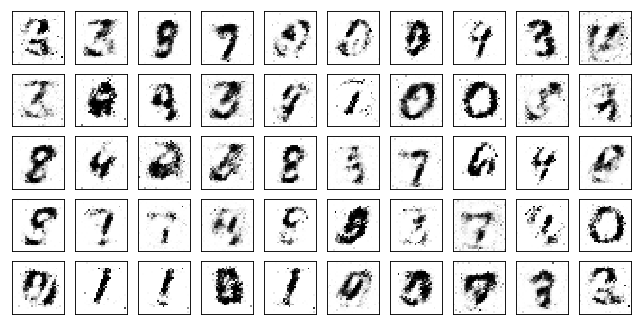

Test losses. G: 2.2766, D: 0.1981
Train Epoch: 11 [0/50000 (0%)]	Losses G: 3.0462, D: 0.2729
Train Epoch: 11 [5000/50000 (10%)]	Losses G: 2.7695, D: 0.1957
Train Epoch: 11 [10000/50000 (20%)]	Losses G: 2.4554, D: 0.2547
Train Epoch: 11 [15000/50000 (30%)]	Losses G: 3.0000, D: 0.3360
Train Epoch: 11 [20000/50000 (40%)]	Losses G: 2.2122, D: 0.3182
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 3.4121, D: 0.2280
Train Epoch: 11 [30000/50000 (60%)]	Losses G: 2.1503, D: 0.3018
Train Epoch: 11 [35000/50000 (70%)]	Losses G: 2.6582, D: 0.2367
Train Epoch: 11 [40000/50000 (80%)]	Losses G: 2.6849, D: 0.2735
Train Epoch: 11 [45000/50000 (90%)]	Losses G: 2.6916, D: 0.3333
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 2.8093, D: 0.2502
target: tensor([1, 2, 1, 2, 8, 5, 0, 0, 0, 3, 8, 8, 1, 0, 3, 6, 5, 7, 7, 1, 0, 9, 8, 8,
        2, 5, 5, 1, 6, 2, 6, 5, 3, 7, 7, 8, 6, 8, 7, 6, 3, 5, 3, 2, 7, 8, 6, 7,
        1, 5])


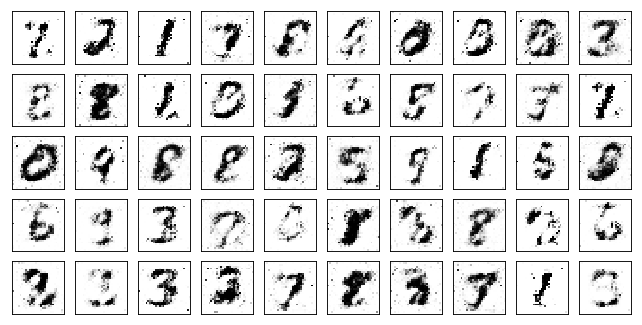

Test losses. G: 2.5544, D: 0.1659
Train Epoch: 12 [0/50000 (0%)]	Losses G: 3.0487, D: 0.2196
Train Epoch: 12 [5000/50000 (10%)]	Losses G: 2.0968, D: 0.3537
Train Epoch: 12 [10000/50000 (20%)]	Losses G: 1.7634, D: 0.4820
Train Epoch: 12 [15000/50000 (30%)]	Losses G: 1.7906, D: 0.3886
Train Epoch: 12 [20000/50000 (40%)]	Losses G: 1.8839, D: 0.3026
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 2.2056, D: 0.3392
Train Epoch: 12 [30000/50000 (60%)]	Losses G: 2.1618, D: 0.3225
Train Epoch: 12 [35000/50000 (70%)]	Losses G: 2.4813, D: 0.3712
Train Epoch: 12 [40000/50000 (80%)]	Losses G: 1.6409, D: 0.3223
Train Epoch: 12 [45000/50000 (90%)]	Losses G: 1.7819, D: 0.2375
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 2.0767, D: 0.3576
target: tensor([4, 1, 7, 0, 7, 1, 2, 4, 9, 3, 7, 1, 8, 2, 9, 2, 0, 5, 8, 0, 1, 6, 8, 7,
        4, 8, 0, 1, 0, 0, 4, 6, 6, 0, 5, 0, 6, 8, 3, 0, 5, 3, 6, 4, 5, 3, 5, 5,
        9, 2])


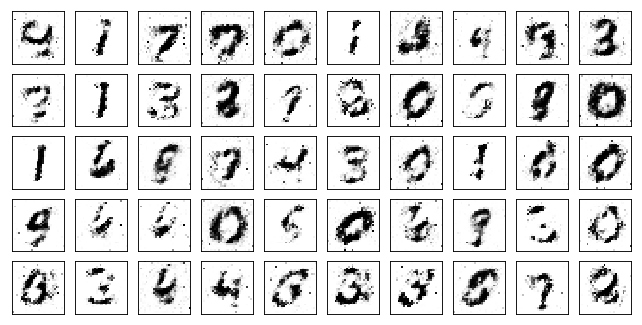

Test losses. G: 1.8193, D: 0.2697
Train Epoch: 13 [0/50000 (0%)]	Losses G: 1.6929, D: 0.3369
Train Epoch: 13 [5000/50000 (10%)]	Losses G: 2.4397, D: 0.2661
Train Epoch: 13 [10000/50000 (20%)]	Losses G: 2.2876, D: 0.3616
Train Epoch: 13 [15000/50000 (30%)]	Losses G: 2.3236, D: 0.3274
Train Epoch: 13 [20000/50000 (40%)]	Losses G: 1.8028, D: 0.3754
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 2.1137, D: 0.3770
Train Epoch: 13 [30000/50000 (60%)]	Losses G: 2.0780, D: 0.4501
Train Epoch: 13 [35000/50000 (70%)]	Losses G: 1.8138, D: 0.4103
Train Epoch: 13 [40000/50000 (80%)]	Losses G: 2.1725, D: 0.4290
Train Epoch: 13 [45000/50000 (90%)]	Losses G: 1.8973, D: 0.4128
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 3.1206, D: 0.3611
target: tensor([1, 0, 1, 7, 5, 9, 2, 2, 5, 1, 1, 5, 8, 1, 7, 0, 1, 4, 9, 4, 1, 1, 1, 7,
        8, 7, 9, 9, 3, 1, 0, 9, 6, 1, 9, 4, 7, 9, 9, 7, 7, 1, 1, 9, 0, 8, 4, 7,
        9, 3])


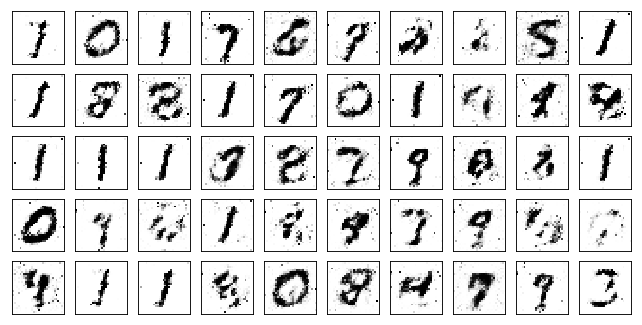

Test losses. G: 2.8084, D: 0.2483
Train Epoch: 14 [0/50000 (0%)]	Losses G: 2.8030, D: 0.3512
Train Epoch: 14 [5000/50000 (10%)]	Losses G: 2.3456, D: 0.3322
Train Epoch: 14 [10000/50000 (20%)]	Losses G: 2.1095, D: 0.4204
Train Epoch: 14 [15000/50000 (30%)]	Losses G: 1.9658, D: 0.2900
Train Epoch: 14 [20000/50000 (40%)]	Losses G: 1.9512, D: 0.3775
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 2.0608, D: 0.4303
Train Epoch: 14 [30000/50000 (60%)]	Losses G: 2.3525, D: 0.3678
Train Epoch: 14 [35000/50000 (70%)]	Losses G: 2.0720, D: 0.3617
Train Epoch: 14 [40000/50000 (80%)]	Losses G: 2.0912, D: 0.3201
Train Epoch: 14 [45000/50000 (90%)]	Losses G: 1.7962, D: 0.3933
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 1.5106, D: 0.5036
target: tensor([0, 0, 2, 1, 0, 2, 7, 9, 3, 6, 3, 9, 4, 3, 7, 7, 5, 6, 4, 7, 4, 5, 0, 2,
        1, 0, 4, 0, 7, 9, 6, 4, 1, 1, 3, 0, 7, 4, 2, 4, 4, 4, 6, 7, 8, 5, 9, 1,
        7, 4])


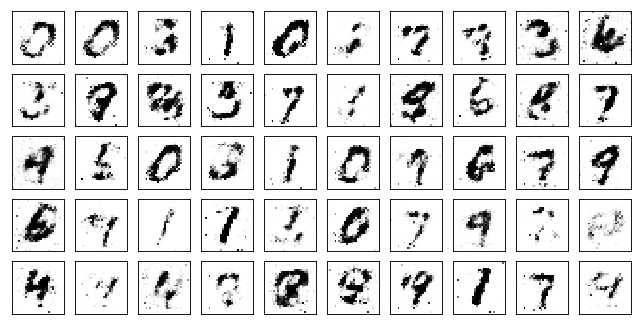

Test losses. G: 1.4301, D: 0.3557
Train Epoch: 15 [0/50000 (0%)]	Losses G: 1.9690, D: 0.3647
Train Epoch: 15 [5000/50000 (10%)]	Losses G: 1.9930, D: 0.3624
Train Epoch: 15 [10000/50000 (20%)]	Losses G: 2.1468, D: 0.4128
Train Epoch: 15 [15000/50000 (30%)]	Losses G: 2.0431, D: 0.3408
Train Epoch: 15 [20000/50000 (40%)]	Losses G: 2.1721, D: 0.4065
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 2.5508, D: 0.3879
Train Epoch: 15 [30000/50000 (60%)]	Losses G: 1.5890, D: 0.3514
Train Epoch: 15 [35000/50000 (70%)]	Losses G: 2.0109, D: 0.3947
Train Epoch: 15 [40000/50000 (80%)]	Losses G: 1.6644, D: 0.2571
Train Epoch: 15 [45000/50000 (90%)]	Losses G: 1.9142, D: 0.3717
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 1.8382, D: 0.3372
target: tensor([3, 2, 0, 0, 2, 4, 3, 9, 7, 0, 1, 0, 3, 8, 4, 1, 6, 3, 3, 1, 4, 6, 5, 7,
        0, 5, 7, 5, 0, 9, 3, 9, 4, 2, 6, 0, 6, 1, 8, 1, 0, 2, 8, 7, 9, 9, 9, 2,
        0, 4])


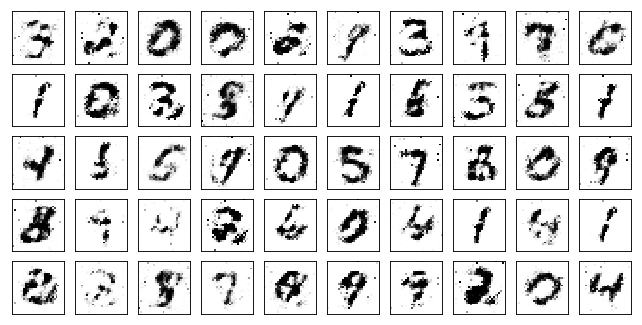

Test losses. G: 1.8548, D: 0.2687
Train Epoch: 16 [0/50000 (0%)]	Losses G: 1.9332, D: 0.3836
Train Epoch: 16 [5000/50000 (10%)]	Losses G: 2.7465, D: 0.2830
Train Epoch: 16 [10000/50000 (20%)]	Losses G: 1.2603, D: 0.5070
Train Epoch: 16 [15000/50000 (30%)]	Losses G: 1.9789, D: 0.3640
Train Epoch: 16 [20000/50000 (40%)]	Losses G: 1.7299, D: 0.3351
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 1.8406, D: 0.4006
Train Epoch: 16 [30000/50000 (60%)]	Losses G: 1.3634, D: 0.4122
Train Epoch: 16 [35000/50000 (70%)]	Losses G: 1.6659, D: 0.3492
Train Epoch: 16 [40000/50000 (80%)]	Losses G: 2.2343, D: 0.3792
Train Epoch: 16 [45000/50000 (90%)]	Losses G: 2.3552, D: 0.3094
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 2.1162, D: 0.4638
target: tensor([3, 6, 8, 9, 6, 3, 2, 3, 3, 4, 3, 2, 7, 4, 2, 9, 0, 1, 1, 1, 3, 5, 7, 3,
        0, 8, 1, 6, 6, 5, 0, 9, 4, 1, 1, 1, 9, 2, 5, 8, 4, 7, 4, 8, 8, 4, 6, 1,
        9, 4])


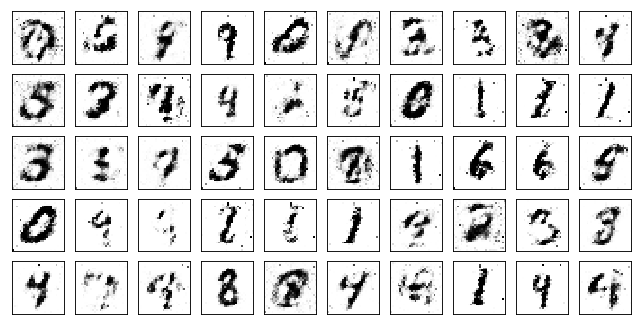

Test losses. G: 1.9536, D: 0.3267
Train Epoch: 17 [0/50000 (0%)]	Losses G: 2.0817, D: 0.3944
Train Epoch: 17 [5000/50000 (10%)]	Losses G: 1.9236, D: 0.4297
Train Epoch: 17 [10000/50000 (20%)]	Losses G: 1.6540, D: 0.3888
Train Epoch: 17 [15000/50000 (30%)]	Losses G: 2.1464, D: 0.3218
Train Epoch: 17 [20000/50000 (40%)]	Losses G: 2.2347, D: 0.4333
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 1.6357, D: 0.4968
Train Epoch: 17 [30000/50000 (60%)]	Losses G: 1.5351, D: 0.3931
Train Epoch: 17 [35000/50000 (70%)]	Losses G: 1.6133, D: 0.4963
Train Epoch: 17 [40000/50000 (80%)]	Losses G: 1.8238, D: 0.4156
Train Epoch: 17 [45000/50000 (90%)]	Losses G: 2.2882, D: 0.4082
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 1.4732, D: 0.3914
target: tensor([0, 8, 3, 9, 2, 5, 8, 2, 5, 5, 5, 8, 8, 3, 3, 6, 1, 5, 1, 2, 5, 3, 4, 5,
        8, 4, 1, 6, 3, 2, 5, 0, 3, 5, 4, 5, 6, 7, 7, 8, 0, 5, 3, 2, 4, 8, 3, 9,
        0, 3])


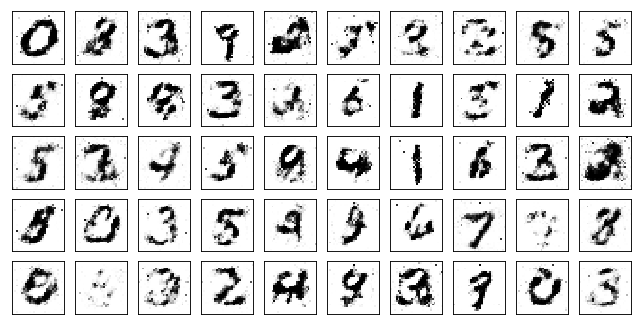

Test losses. G: 1.5114, D: 0.2795
Train Epoch: 18 [0/50000 (0%)]	Losses G: 2.0804, D: 0.3348
Train Epoch: 18 [5000/50000 (10%)]	Losses G: 1.7909, D: 0.3457
Train Epoch: 18 [10000/50000 (20%)]	Losses G: 1.4559, D: 0.5347
Train Epoch: 18 [15000/50000 (30%)]	Losses G: 1.6621, D: 0.3487
Train Epoch: 18 [20000/50000 (40%)]	Losses G: 1.7277, D: 0.3457
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 1.7854, D: 0.3752
Train Epoch: 18 [30000/50000 (60%)]	Losses G: 1.7831, D: 0.3889
Train Epoch: 18 [35000/50000 (70%)]	Losses G: 2.0382, D: 0.3620
Train Epoch: 18 [40000/50000 (80%)]	Losses G: 2.0510, D: 0.3966
Train Epoch: 18 [45000/50000 (90%)]	Losses G: 1.9530, D: 0.3484
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 1.7417, D: 0.5179
target: tensor([8, 7, 1, 5, 6, 8, 6, 5, 2, 8, 3, 1, 4, 9, 2, 1, 4, 2, 9, 6, 2, 6, 9, 1,
        8, 0, 5, 2, 5, 2, 8, 2, 0, 9, 2, 3, 8, 6, 1, 7, 0, 4, 9, 2, 4, 1, 7, 2,
        8, 6])


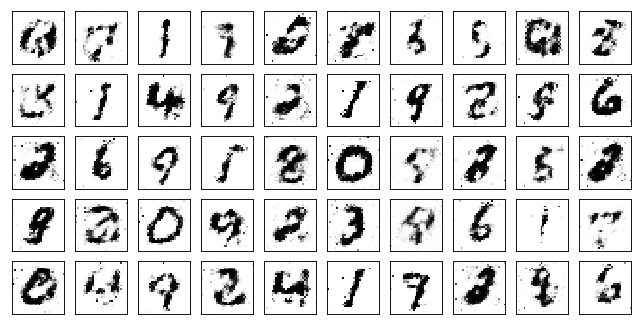

Test losses. G: 1.4492, D: 0.3840
Train Epoch: 19 [0/50000 (0%)]	Losses G: 1.6654, D: 0.4702
Train Epoch: 19 [5000/50000 (10%)]	Losses G: 1.3645, D: 0.4368
Train Epoch: 19 [10000/50000 (20%)]	Losses G: 1.3014, D: 0.3796
Train Epoch: 19 [15000/50000 (30%)]	Losses G: 1.7265, D: 0.3305
Train Epoch: 19 [20000/50000 (40%)]	Losses G: 1.2206, D: 0.4643
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 1.7599, D: 0.3971
Train Epoch: 19 [30000/50000 (60%)]	Losses G: 1.4931, D: 0.4404
Train Epoch: 19 [35000/50000 (70%)]	Losses G: 1.9493, D: 0.4228
Train Epoch: 19 [40000/50000 (80%)]	Losses G: 1.1238, D: 0.4530
Train Epoch: 19 [45000/50000 (90%)]	Losses G: 1.7051, D: 0.4646
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 1.8290, D: 0.5097
target: tensor([0, 6, 6, 4, 0, 0, 6, 8, 2, 2, 0, 9, 8, 2, 4, 0, 5, 6, 7, 6, 0, 8, 2, 4,
        1, 1, 5, 1, 9, 8, 8, 8, 7, 0, 3, 5, 3, 0, 7, 1, 1, 6, 1, 2, 1, 1, 6, 2,
        1, 0])


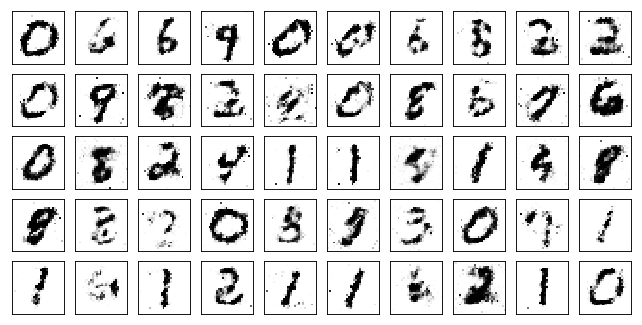

Test losses. G: 1.9227, D: 0.3684
Train Epoch: 20 [0/50000 (0%)]	Losses G: 2.3475, D: 0.4589
Train Epoch: 20 [5000/50000 (10%)]	Losses G: 1.5832, D: 0.3835
Train Epoch: 20 [10000/50000 (20%)]	Losses G: 1.5219, D: 0.4292
Train Epoch: 20 [15000/50000 (30%)]	Losses G: 1.6903, D: 0.4135
Train Epoch: 20 [20000/50000 (40%)]	Losses G: 1.6441, D: 0.4702
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 1.3506, D: 0.4459
Train Epoch: 20 [30000/50000 (60%)]	Losses G: 1.6133, D: 0.6165
Train Epoch: 20 [35000/50000 (70%)]	Losses G: 1.6617, D: 0.4940
Train Epoch: 20 [40000/50000 (80%)]	Losses G: 1.2804, D: 0.4355
Train Epoch: 20 [45000/50000 (90%)]	Losses G: 1.5211, D: 0.5573
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 1.6295, D: 0.5043
target: tensor([4, 0, 4, 7, 0, 1, 9, 5, 6, 5, 1, 0, 1, 7, 5, 7, 0, 9, 7, 4, 4, 6, 7, 5,
        7, 9, 3, 8, 9, 8, 7, 6, 7, 5, 1, 8, 0, 2, 2, 6, 8, 0, 3, 9, 1, 2, 2, 9,
        9, 5])


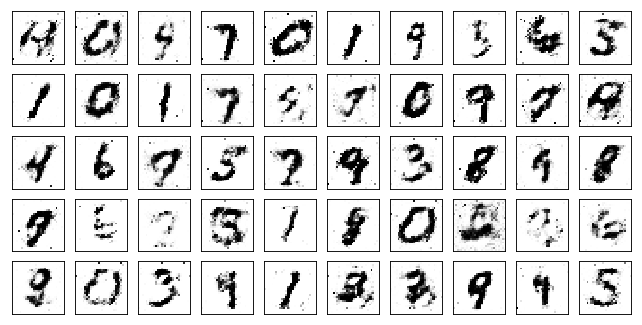

Test losses. G: 1.5033, D: 0.4637
Train Epoch: 21 [0/50000 (0%)]	Losses G: 1.5771, D: 0.4880
Train Epoch: 21 [5000/50000 (10%)]	Losses G: 1.6416, D: 0.4805
Train Epoch: 21 [10000/50000 (20%)]	Losses G: 1.9133, D: 0.5182
Train Epoch: 21 [15000/50000 (30%)]	Losses G: 1.3380, D: 0.4758
Train Epoch: 21 [20000/50000 (40%)]	Losses G: 1.7112, D: 0.4202
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 1.5284, D: 0.3679
Train Epoch: 21 [30000/50000 (60%)]	Losses G: 1.3493, D: 0.5017
Train Epoch: 21 [35000/50000 (70%)]	Losses G: 1.4646, D: 0.4162
Train Epoch: 21 [40000/50000 (80%)]	Losses G: 1.9340, D: 0.3881
Train Epoch: 21 [45000/50000 (90%)]	Losses G: 1.4368, D: 0.3601
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 2.1236, D: 0.3776
target: tensor([6, 7, 0, 7, 1, 9, 4, 9, 9, 3, 4, 5, 0, 1, 0, 2, 5, 1, 9, 9, 2, 6, 8, 5,
        3, 8, 3, 2, 0, 0, 9, 0, 6, 9, 5, 5, 6, 4, 5, 6, 6, 1, 8, 9, 1, 2, 3, 6,
        7, 4])


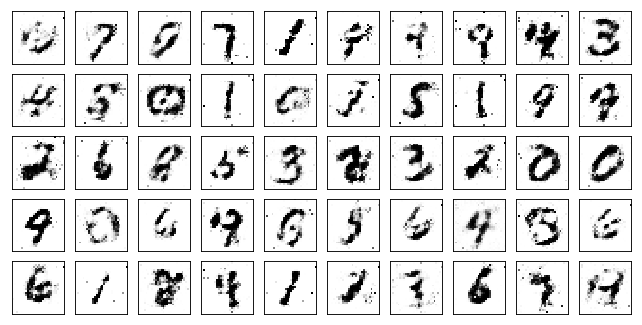

Test losses. G: 1.8468, D: 0.3470
Train Epoch: 22 [0/50000 (0%)]	Losses G: 1.8965, D: 0.4716
Train Epoch: 22 [5000/50000 (10%)]	Losses G: 1.5023, D: 0.4856
Train Epoch: 22 [10000/50000 (20%)]	Losses G: 1.6755, D: 0.5081
Train Epoch: 22 [15000/50000 (30%)]	Losses G: 1.4939, D: 0.4568
Train Epoch: 22 [20000/50000 (40%)]	Losses G: 0.9858, D: 0.6352
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 1.7175, D: 0.5151
Train Epoch: 22 [30000/50000 (60%)]	Losses G: 1.7134, D: 0.5103
Train Epoch: 22 [35000/50000 (70%)]	Losses G: 1.5549, D: 0.4441
Train Epoch: 22 [40000/50000 (80%)]	Losses G: 1.4662, D: 0.4731
Train Epoch: 22 [45000/50000 (90%)]	Losses G: 1.8218, D: 0.3465
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 1.8295, D: 0.5744
target: tensor([4, 6, 3, 3, 1, 7, 7, 3, 7, 3, 1, 9, 9, 4, 3, 7, 0, 1, 0, 1, 3, 9, 5, 8,
        5, 7, 5, 2, 1, 5, 4, 6, 7, 7, 9, 1, 9, 0, 2, 4, 1, 6, 2, 5, 6, 0, 3, 7,
        0, 3])


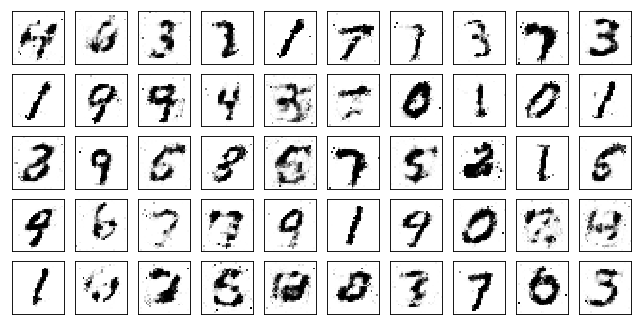

Test losses. G: 1.7002, D: 0.3871
Train Epoch: 23 [0/50000 (0%)]	Losses G: 1.4811, D: 0.3964
Train Epoch: 23 [5000/50000 (10%)]	Losses G: 1.2254, D: 0.4026
Train Epoch: 23 [10000/50000 (20%)]	Losses G: 1.5877, D: 0.4429
Train Epoch: 23 [15000/50000 (30%)]	Losses G: 1.3629, D: 0.4986
Train Epoch: 23 [20000/50000 (40%)]	Losses G: 1.1513, D: 0.5130
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 1.3087, D: 0.6045
Train Epoch: 23 [30000/50000 (60%)]	Losses G: 1.2074, D: 0.6057
Train Epoch: 23 [35000/50000 (70%)]	Losses G: 1.5131, D: 0.5489
Train Epoch: 23 [40000/50000 (80%)]	Losses G: 1.4374, D: 0.4380
Train Epoch: 23 [45000/50000 (90%)]	Losses G: 1.2014, D: 0.5610
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 1.3962, D: 0.5768
target: tensor([9, 7, 7, 3, 4, 3, 2, 2, 6, 6, 4, 8, 1, 4, 1, 7, 3, 0, 8, 8, 8, 3, 2, 5,
        5, 8, 1, 3, 1, 3, 8, 7, 1, 2, 2, 3, 2, 9, 7, 3, 4, 3, 1, 2, 4, 7, 8, 6,
        5, 6])


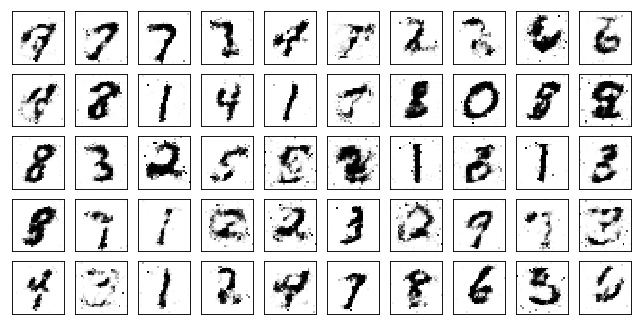

Test losses. G: 1.2257, D: 0.4472
Train Epoch: 24 [0/50000 (0%)]	Losses G: 1.2106, D: 0.4235
Train Epoch: 24 [5000/50000 (10%)]	Losses G: 1.5103, D: 0.4558
Train Epoch: 24 [10000/50000 (20%)]	Losses G: 1.4845, D: 0.3974
Train Epoch: 24 [15000/50000 (30%)]	Losses G: 1.5129, D: 0.4436
Train Epoch: 24 [20000/50000 (40%)]	Losses G: 1.5245, D: 0.5161
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 1.5887, D: 0.4259
Train Epoch: 24 [30000/50000 (60%)]	Losses G: 1.2308, D: 0.4774
Train Epoch: 24 [35000/50000 (70%)]	Losses G: 1.4740, D: 0.5108
Train Epoch: 24 [40000/50000 (80%)]	Losses G: 1.3756, D: 0.6201
Train Epoch: 24 [45000/50000 (90%)]	Losses G: 1.5279, D: 0.5815
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 1.7374, D: 0.4174
target: tensor([9, 1, 9, 7, 8, 7, 4, 8, 5, 5, 7, 5, 5, 3, 4, 7, 2, 9, 6, 8, 6, 1, 2, 2,
        9, 1, 3, 9, 5, 8, 2, 9, 8, 8, 0, 4, 8, 9, 7, 7, 1, 8, 0, 7, 1, 0, 4, 4,
        5, 2])


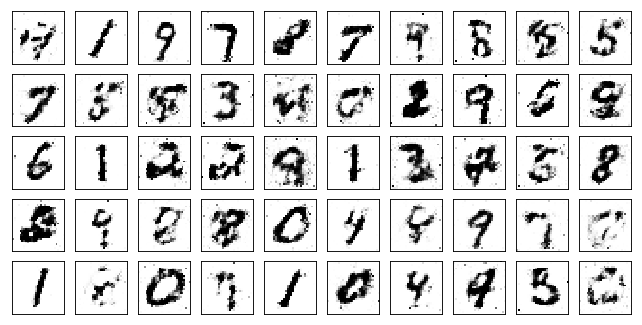

Test losses. G: 1.5405, D: 0.4109
Train Epoch: 25 [0/50000 (0%)]	Losses G: 1.8256, D: 0.4058
Train Epoch: 25 [5000/50000 (10%)]	Losses G: 1.6566, D: 0.4591
Train Epoch: 25 [10000/50000 (20%)]	Losses G: 1.3288, D: 0.4451
Train Epoch: 25 [15000/50000 (30%)]	Losses G: 1.3155, D: 0.4743
Train Epoch: 25 [20000/50000 (40%)]	Losses G: 1.4930, D: 0.5184
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 1.0235, D: 0.5563
Train Epoch: 25 [30000/50000 (60%)]	Losses G: 1.3729, D: 0.4910
Train Epoch: 25 [35000/50000 (70%)]	Losses G: 1.6515, D: 0.4057
Train Epoch: 25 [40000/50000 (80%)]	Losses G: 1.2703, D: 0.5387
Train Epoch: 25 [45000/50000 (90%)]	Losses G: 1.1092, D: 0.5262
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.5668, D: 0.5466
target: tensor([3, 0, 3, 4, 9, 2, 8, 3, 8, 6, 9, 4, 5, 0, 3, 3, 1, 7, 7, 4, 7, 7, 0, 9,
        6, 4, 2, 9, 3, 5, 8, 8, 8, 4, 4, 2, 3, 8, 7, 0, 1, 2, 9, 1, 1, 6, 5, 7,
        7, 1])


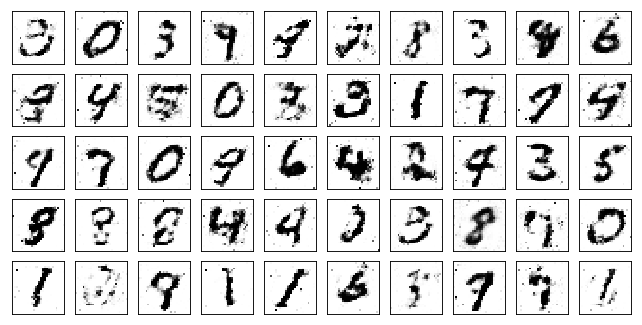

Test losses. G: 1.4151, D: 0.4654
Train Epoch: 26 [0/50000 (0%)]	Losses G: 1.5280, D: 0.4513
Train Epoch: 26 [5000/50000 (10%)]	Losses G: 1.3183, D: 0.4640
Train Epoch: 26 [10000/50000 (20%)]	Losses G: 1.3993, D: 0.4913
Train Epoch: 26 [15000/50000 (30%)]	Losses G: 1.4965, D: 0.5477
Train Epoch: 26 [20000/50000 (40%)]	Losses G: 1.2897, D: 0.5591
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 1.3696, D: 0.4922
Train Epoch: 26 [30000/50000 (60%)]	Losses G: 1.4782, D: 0.5177
Train Epoch: 26 [35000/50000 (70%)]	Losses G: 1.4581, D: 0.4635
Train Epoch: 26 [40000/50000 (80%)]	Losses G: 1.1892, D: 0.4791
Train Epoch: 26 [45000/50000 (90%)]	Losses G: 1.0033, D: 0.5152
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 1.4217, D: 0.5148
target: tensor([9, 7, 1, 9, 5, 2, 6, 3, 3, 9, 2, 3, 4, 0, 1, 4, 8, 7, 0, 2, 5, 1, 9, 4,
        9, 4, 9, 5, 9, 2, 7, 2, 4, 0, 4, 4, 4, 3, 1, 5, 9, 2, 3, 2, 1, 4, 4, 4,
        4, 6])


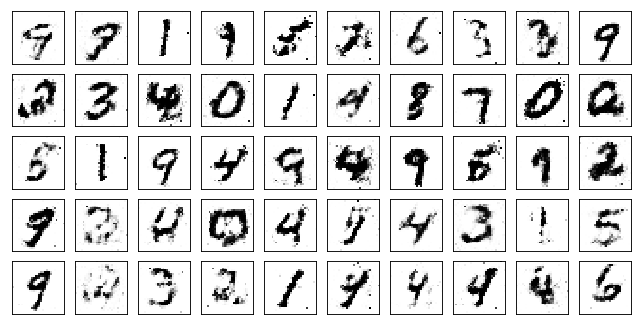

Test losses. G: 1.3995, D: 0.4236
Train Epoch: 27 [0/50000 (0%)]	Losses G: 1.3077, D: 0.3971
Train Epoch: 27 [5000/50000 (10%)]	Losses G: 1.4090, D: 0.5386
Train Epoch: 27 [10000/50000 (20%)]	Losses G: 1.3051, D: 0.5609
Train Epoch: 27 [15000/50000 (30%)]	Losses G: 1.1413, D: 0.5069
Train Epoch: 27 [20000/50000 (40%)]	Losses G: 1.5173, D: 0.5381
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 1.5199, D: 0.5709
Train Epoch: 27 [30000/50000 (60%)]	Losses G: 1.6609, D: 0.4649
Train Epoch: 27 [35000/50000 (70%)]	Losses G: 0.9979, D: 0.6205
Train Epoch: 27 [40000/50000 (80%)]	Losses G: 1.2640, D: 0.5690
Train Epoch: 27 [45000/50000 (90%)]	Losses G: 1.4505, D: 0.5030
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 1.0321, D: 0.4966
target: tensor([1, 4, 9, 5, 2, 5, 1, 6, 8, 1, 7, 9, 8, 3, 9, 3, 5, 6, 4, 7, 2, 9, 0, 7,
        4, 5, 2, 6, 9, 9, 8, 0, 8, 1, 6, 1, 9, 3, 5, 7, 9, 1, 4, 6, 8, 7, 8, 1,
        1, 4])


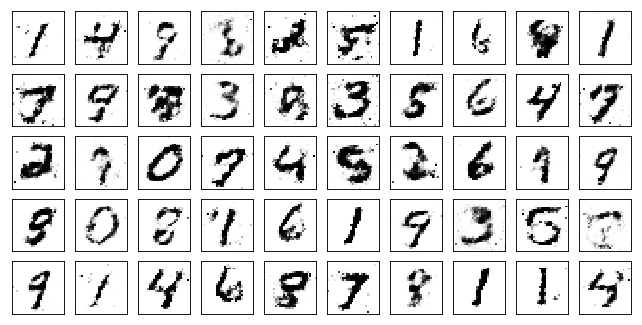

Test losses. G: 0.9990, D: 0.4742
Train Epoch: 28 [0/50000 (0%)]	Losses G: 0.9774, D: 0.5623
Train Epoch: 28 [5000/50000 (10%)]	Losses G: 1.2190, D: 0.5034
Train Epoch: 28 [10000/50000 (20%)]	Losses G: 1.0353, D: 0.5258
Train Epoch: 28 [15000/50000 (30%)]	Losses G: 1.4961, D: 0.4679
Train Epoch: 28 [20000/50000 (40%)]	Losses G: 1.3418, D: 0.4498
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 1.1494, D: 0.5600
Train Epoch: 28 [30000/50000 (60%)]	Losses G: 1.1984, D: 0.4764
Train Epoch: 28 [35000/50000 (70%)]	Losses G: 0.8443, D: 0.4831
Train Epoch: 28 [40000/50000 (80%)]	Losses G: 1.4251, D: 0.6139
Train Epoch: 28 [45000/50000 (90%)]	Losses G: 1.1541, D: 0.5244
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 0.9841, D: 0.4436
target: tensor([7, 7, 3, 0, 5, 6, 1, 7, 7, 2, 3, 1, 8, 2, 7, 5, 5, 3, 7, 3, 2, 7, 5, 8,
        6, 1, 6, 1, 2, 3, 3, 0, 1, 1, 6, 5, 9, 6, 1, 5, 5, 9, 9, 1, 4, 4, 1, 6,
        2, 7])


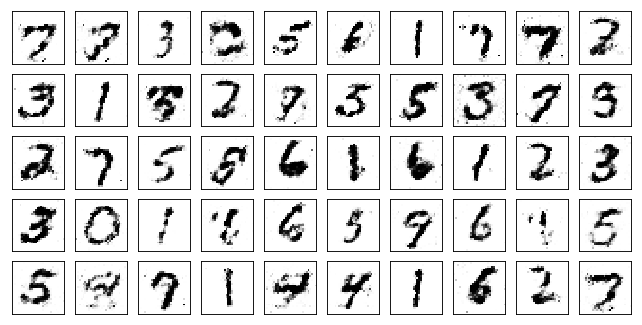

Test losses. G: 1.1116, D: 0.4760
Train Epoch: 29 [0/50000 (0%)]	Losses G: 1.0959, D: 0.5406
Train Epoch: 29 [5000/50000 (10%)]	Losses G: 1.2021, D: 0.5313
Train Epoch: 29 [10000/50000 (20%)]	Losses G: 1.2510, D: 0.4982
Train Epoch: 29 [15000/50000 (30%)]	Losses G: 1.4177, D: 0.5331
Train Epoch: 29 [20000/50000 (40%)]	Losses G: 1.3447, D: 0.5995
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 1.3843, D: 0.6066
Train Epoch: 29 [30000/50000 (60%)]	Losses G: 1.1411, D: 0.4678
Train Epoch: 29 [35000/50000 (70%)]	Losses G: 1.1140, D: 0.5226
Train Epoch: 29 [40000/50000 (80%)]	Losses G: 1.5519, D: 0.4543
Train Epoch: 29 [45000/50000 (90%)]	Losses G: 0.9314, D: 0.5396
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 0.9738, D: 0.5583
target: tensor([4, 1, 7, 8, 2, 7, 5, 5, 7, 9, 3, 8, 5, 6, 8, 1, 6, 1, 4, 8, 0, 3, 0, 5,
        5, 4, 1, 5, 8, 8, 1, 6, 7, 9, 4, 7, 2, 0, 4, 2, 3, 6, 3, 4, 2, 6, 5, 9,
        8, 1])


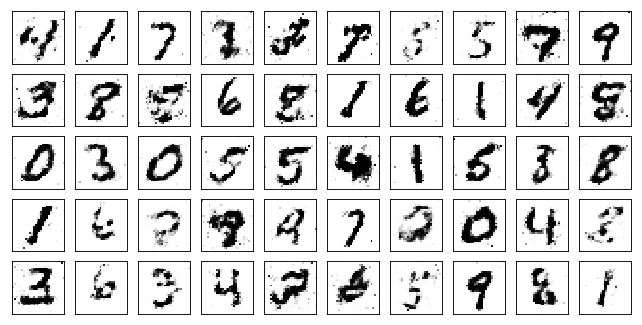

Test losses. G: 1.0732, D: 0.5151
Train Epoch: 30 [0/50000 (0%)]	Losses G: 1.1239, D: 0.5469
Train Epoch: 30 [5000/50000 (10%)]	Losses G: 1.1713, D: 0.5423
Train Epoch: 30 [10000/50000 (20%)]	Losses G: 0.9725, D: 0.5840
Train Epoch: 30 [15000/50000 (30%)]	Losses G: 1.3387, D: 0.6750
Train Epoch: 30 [20000/50000 (40%)]	Losses G: 1.2265, D: 0.5286
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 1.3242, D: 0.5350
Train Epoch: 30 [30000/50000 (60%)]	Losses G: 1.4206, D: 0.6450
Train Epoch: 30 [35000/50000 (70%)]	Losses G: 1.2595, D: 0.4714
Train Epoch: 30 [40000/50000 (80%)]	Losses G: 0.9941, D: 0.5707
Train Epoch: 30 [45000/50000 (90%)]	Losses G: 1.4039, D: 0.5547
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 1.0631, D: 0.5254
target: tensor([6, 0, 5, 4, 5, 1, 1, 2, 2, 3, 5, 1, 3, 7, 0, 6, 5, 8, 7, 6, 9, 2, 1, 8,
        5, 5, 3, 3, 1, 6, 7, 9, 4, 1, 1, 0, 7, 4, 8, 3, 9, 8, 3, 2, 2, 2, 8, 5,
        9, 7])


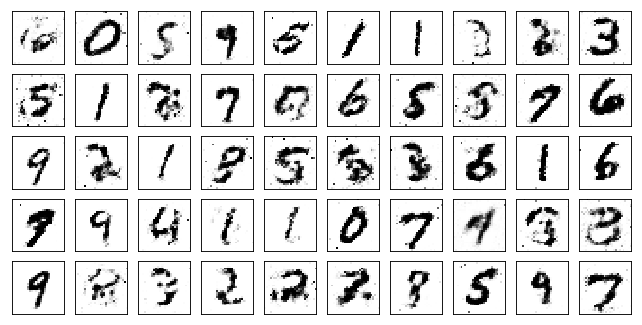

Test losses. G: 1.0998, D: 0.4596
Train Epoch: 31 [0/50000 (0%)]	Losses G: 1.2529, D: 0.5640
Train Epoch: 31 [5000/50000 (10%)]	Losses G: 1.1793, D: 0.4654
Train Epoch: 31 [10000/50000 (20%)]	Losses G: 1.3517, D: 0.5411
Train Epoch: 31 [15000/50000 (30%)]	Losses G: 1.1924, D: 0.4916
Train Epoch: 31 [20000/50000 (40%)]	Losses G: 1.1313, D: 0.5170
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 1.1049, D: 0.6065
Train Epoch: 31 [30000/50000 (60%)]	Losses G: 1.1670, D: 0.4753
Train Epoch: 31 [35000/50000 (70%)]	Losses G: 1.1475, D: 0.5988
Train Epoch: 31 [40000/50000 (80%)]	Losses G: 1.3721, D: 0.5099
Train Epoch: 31 [45000/50000 (90%)]	Losses G: 1.1786, D: 0.5224
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 1.2854, D: 0.6680
target: tensor([9, 7, 5, 4, 3, 8, 7, 1, 3, 4, 6, 3, 2, 2, 8, 0, 7, 2, 4, 2, 4, 2, 0, 5,
        8, 9, 5, 6, 9, 0, 2, 1, 6, 9, 8, 2, 0, 0, 3, 3, 7, 8, 6, 6, 6, 9, 7, 4,
        3, 5])


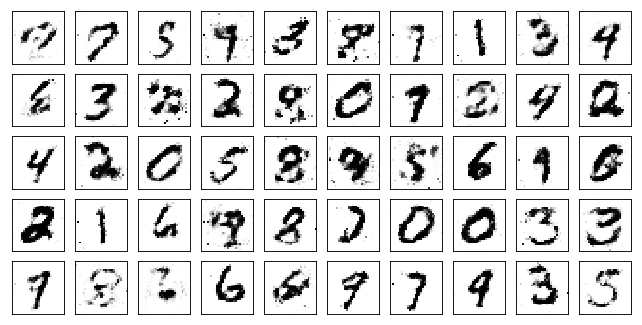

Test losses. G: 1.2026, D: 0.5350
Train Epoch: 32 [0/50000 (0%)]	Losses G: 1.1746, D: 0.5748
Train Epoch: 32 [5000/50000 (10%)]	Losses G: 1.2836, D: 0.5294
Train Epoch: 32 [10000/50000 (20%)]	Losses G: 0.9462, D: 0.5865
Train Epoch: 32 [15000/50000 (30%)]	Losses G: 1.1104, D: 0.4222
Train Epoch: 32 [20000/50000 (40%)]	Losses G: 0.9395, D: 0.5227
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 1.1220, D: 0.5802
Train Epoch: 32 [30000/50000 (60%)]	Losses G: 1.5548, D: 0.5210
Train Epoch: 32 [35000/50000 (70%)]	Losses G: 1.4015, D: 0.5139
Train Epoch: 32 [40000/50000 (80%)]	Losses G: 1.2476, D: 0.5745
Train Epoch: 32 [45000/50000 (90%)]	Losses G: 1.0858, D: 0.5326
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 0.9967, D: 0.5994
target: tensor([6, 6, 3, 4, 1, 2, 2, 2, 4, 0, 8, 0, 1, 2, 3, 5, 1, 4, 2, 8, 0, 4, 5, 9,
        8, 7, 9, 9, 9, 1, 6, 3, 9, 2, 9, 4, 1, 9, 2, 7, 3, 2, 9, 7, 1, 7, 5, 4,
        9, 9])


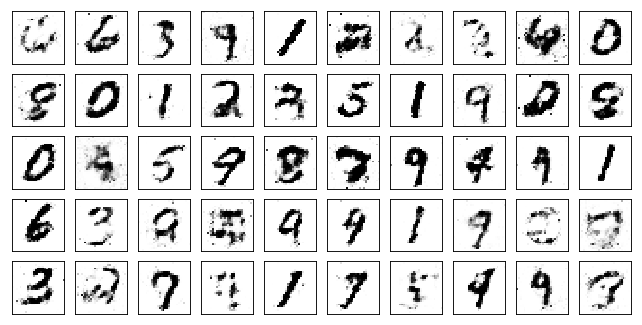

Test losses. G: 0.9471, D: 0.5505
Train Epoch: 33 [0/50000 (0%)]	Losses G: 1.0684, D: 0.5983
Train Epoch: 33 [5000/50000 (10%)]	Losses G: 1.1460, D: 0.5346
Train Epoch: 33 [10000/50000 (20%)]	Losses G: 1.3133, D: 0.6826
Train Epoch: 33 [15000/50000 (30%)]	Losses G: 1.3159, D: 0.5523
Train Epoch: 33 [20000/50000 (40%)]	Losses G: 1.1701, D: 0.6241
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 1.1055, D: 0.5500
Train Epoch: 33 [30000/50000 (60%)]	Losses G: 1.1904, D: 0.5167
Train Epoch: 33 [35000/50000 (70%)]	Losses G: 0.9054, D: 0.5857
Train Epoch: 33 [40000/50000 (80%)]	Losses G: 1.0240, D: 0.7123
Train Epoch: 33 [45000/50000 (90%)]	Losses G: 1.1075, D: 0.5408
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 1.0294, D: 0.5622
target: tensor([3, 2, 4, 0, 9, 5, 1, 2, 3, 3, 2, 0, 8, 1, 9, 2, 0, 0, 5, 8, 5, 5, 9, 4,
        6, 3, 3, 7, 3, 7, 8, 8, 2, 4, 0, 9, 9, 7, 1, 0, 6, 2, 0, 3, 2, 5, 4, 1,
        8, 3])


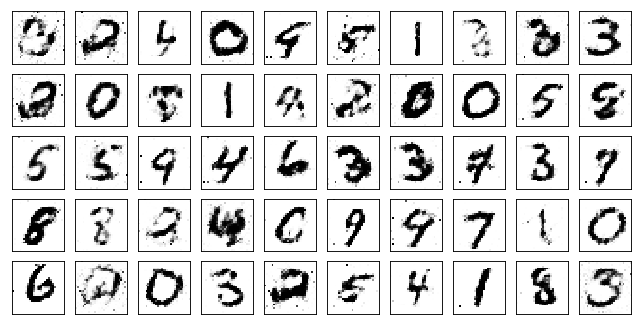

Test losses. G: 1.0155, D: 0.5696
Train Epoch: 34 [0/50000 (0%)]	Losses G: 1.0581, D: 0.6126
Train Epoch: 34 [5000/50000 (10%)]	Losses G: 0.9834, D: 0.5774
Train Epoch: 34 [10000/50000 (20%)]	Losses G: 0.9915, D: 0.5721
Train Epoch: 34 [15000/50000 (30%)]	Losses G: 0.9962, D: 0.6128
Train Epoch: 34 [20000/50000 (40%)]	Losses G: 1.4051, D: 0.4641
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 1.0803, D: 0.4787
Train Epoch: 34 [30000/50000 (60%)]	Losses G: 0.9040, D: 0.6176
Train Epoch: 34 [35000/50000 (70%)]	Losses G: 0.9267, D: 0.6780
Train Epoch: 34 [40000/50000 (80%)]	Losses G: 1.0857, D: 0.5318
Train Epoch: 34 [45000/50000 (90%)]	Losses G: 1.0363, D: 0.5773
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 1.5119, D: 0.6688
target: tensor([4, 9, 5, 1, 8, 3, 8, 5, 3, 0, 8, 3, 7, 4, 4, 7, 9, 3, 0, 4, 8, 3, 7, 3,
        2, 7, 4, 1, 1, 5, 0, 9, 6, 3, 3, 1, 1, 1, 8, 1, 5, 9, 2, 2, 7, 7, 1, 2,
        6, 7])


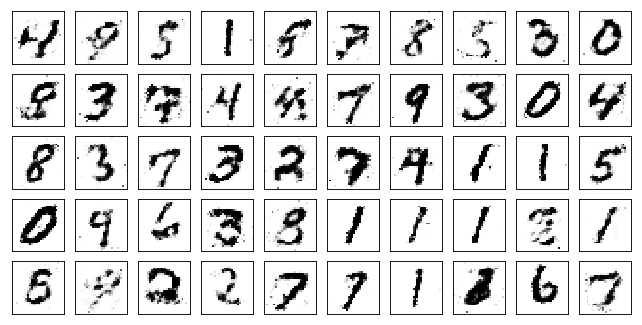

Test losses. G: 1.2122, D: 0.5271
Train Epoch: 35 [0/50000 (0%)]	Losses G: 1.3755, D: 0.5408
Train Epoch: 35 [5000/50000 (10%)]	Losses G: 1.0606, D: 0.5602
Train Epoch: 35 [10000/50000 (20%)]	Losses G: 1.1365, D: 0.7058
Train Epoch: 35 [15000/50000 (30%)]	Losses G: 0.9416, D: 0.6190
Train Epoch: 35 [20000/50000 (40%)]	Losses G: 1.3521, D: 0.5164
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 1.4373, D: 0.5076
Train Epoch: 35 [30000/50000 (60%)]	Losses G: 1.1128, D: 0.5456
Train Epoch: 35 [35000/50000 (70%)]	Losses G: 1.3646, D: 0.5434
Train Epoch: 35 [40000/50000 (80%)]	Losses G: 0.9240, D: 0.6119
Train Epoch: 35 [45000/50000 (90%)]	Losses G: 0.9416, D: 0.5698
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 1.1081, D: 0.4866
target: tensor([9, 4, 7, 3, 2, 4, 8, 0, 5, 3, 4, 3, 6, 5, 3, 8, 4, 8, 2, 2, 6, 1, 6, 2,
        1, 7, 0, 3, 6, 3, 3, 3, 5, 2, 8, 7, 8, 8, 2, 2, 8, 6, 2, 0, 7, 5, 5, 7,
        5, 5])


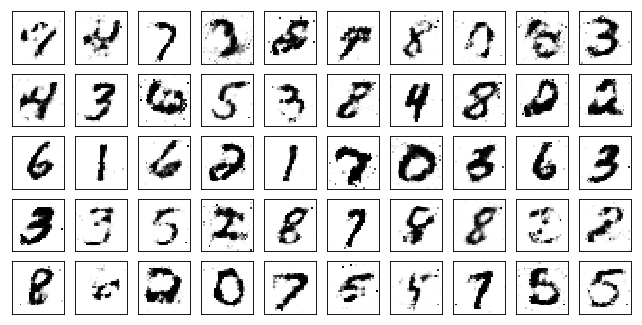

Test losses. G: 0.9850, D: 0.4900
Train Epoch: 36 [0/50000 (0%)]	Losses G: 0.9821, D: 0.5194
Train Epoch: 36 [5000/50000 (10%)]	Losses G: 1.2128, D: 0.5665
Train Epoch: 36 [10000/50000 (20%)]	Losses G: 1.0221, D: 0.7644
Train Epoch: 36 [15000/50000 (30%)]	Losses G: 1.1501, D: 0.5357
Train Epoch: 36 [20000/50000 (40%)]	Losses G: 1.0223, D: 0.6190
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 1.1749, D: 0.7066
Train Epoch: 36 [30000/50000 (60%)]	Losses G: 1.3429, D: 0.4996
Train Epoch: 36 [35000/50000 (70%)]	Losses G: 1.1724, D: 0.4543
Train Epoch: 36 [40000/50000 (80%)]	Losses G: 1.1332, D: 0.6366
Train Epoch: 36 [45000/50000 (90%)]	Losses G: 1.0040, D: 0.5156
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 1.0490, D: 0.5740
target: tensor([5, 5, 9, 2, 4, 1, 8, 5, 6, 6, 6, 0, 4, 4, 5, 7, 1, 9, 5, 3, 4, 7, 4, 8,
        0, 8, 2, 3, 6, 7, 1, 1, 5, 8, 0, 4, 3, 6, 5, 9, 0, 4, 2, 8, 2, 7, 0, 0,
        9, 1])


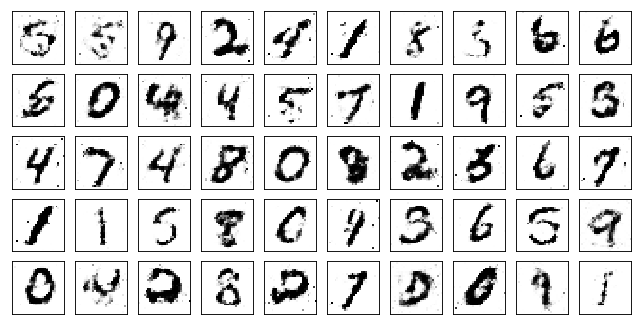

Test losses. G: 1.0653, D: 0.5017
Train Epoch: 37 [0/50000 (0%)]	Losses G: 1.1625, D: 0.5588
Train Epoch: 37 [5000/50000 (10%)]	Losses G: 1.0285, D: 0.6518
Train Epoch: 37 [10000/50000 (20%)]	Losses G: 1.2990, D: 0.5471
Train Epoch: 37 [15000/50000 (30%)]	Losses G: 1.1924, D: 0.5784
Train Epoch: 37 [20000/50000 (40%)]	Losses G: 1.1789, D: 0.6483
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 1.0449, D: 0.5572
Train Epoch: 37 [30000/50000 (60%)]	Losses G: 1.5690, D: 0.5871
Train Epoch: 37 [35000/50000 (70%)]	Losses G: 0.9217, D: 0.6457
Train Epoch: 37 [40000/50000 (80%)]	Losses G: 1.0996, D: 0.5676
Train Epoch: 37 [45000/50000 (90%)]	Losses G: 1.1164, D: 0.6181
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 1.0514, D: 0.5586
target: tensor([8, 5, 1, 0, 8, 5, 9, 2, 7, 2, 9, 7, 2, 1, 0, 6, 7, 2, 5, 5, 6, 5, 4, 5,
        5, 5, 1, 7, 9, 4, 8, 7, 6, 5, 4, 1, 8, 3, 0, 1, 5, 9, 7, 0, 0, 4, 7, 3,
        5, 9])


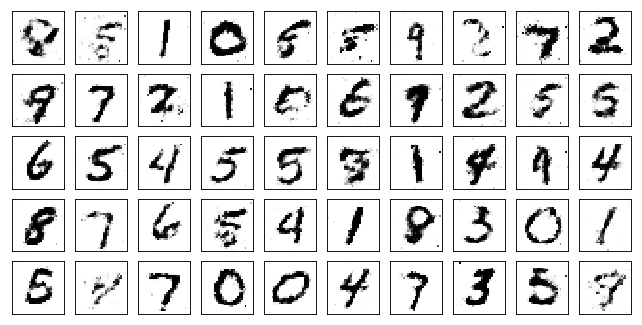

Test losses. G: 1.1178, D: 0.5304
Train Epoch: 38 [0/50000 (0%)]	Losses G: 1.2970, D: 0.5706
Train Epoch: 38 [5000/50000 (10%)]	Losses G: 0.9273, D: 0.5907
Train Epoch: 38 [10000/50000 (20%)]	Losses G: 1.0315, D: 0.5498
Train Epoch: 38 [15000/50000 (30%)]	Losses G: 1.2345, D: 0.5607
Train Epoch: 38 [20000/50000 (40%)]	Losses G: 1.0818, D: 0.5310
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.0194, D: 0.6210
Train Epoch: 38 [30000/50000 (60%)]	Losses G: 1.0070, D: 0.6064
Train Epoch: 38 [35000/50000 (70%)]	Losses G: 0.8856, D: 0.7265
Train Epoch: 38 [40000/50000 (80%)]	Losses G: 1.2282, D: 0.5071
Train Epoch: 38 [45000/50000 (90%)]	Losses G: 0.9166, D: 0.5729
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 0.9705, D: 0.5265
target: tensor([9, 2, 1, 1, 6, 8, 9, 3, 5, 3, 8, 7, 9, 6, 7, 1, 9, 0, 5, 8, 2, 2, 9, 0,
        6, 1, 1, 2, 7, 1, 4, 4, 5, 4, 9, 7, 9, 3, 9, 4, 6, 2, 3, 3, 8, 4, 2, 7,
        0, 7])


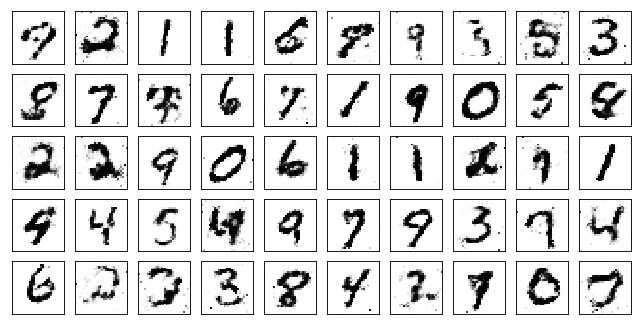

Test losses. G: 0.9852, D: 0.5016
Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.0368, D: 0.5873
Train Epoch: 39 [5000/50000 (10%)]	Losses G: 1.0026, D: 0.6582
Train Epoch: 39 [10000/50000 (20%)]	Losses G: 1.3363, D: 0.5315
Train Epoch: 39 [15000/50000 (30%)]	Losses G: 0.9097, D: 0.5462
Train Epoch: 39 [20000/50000 (40%)]	Losses G: 0.9062, D: 0.6187
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 0.9057, D: 0.7240
Train Epoch: 39 [30000/50000 (60%)]	Losses G: 0.9280, D: 0.6881
Train Epoch: 39 [35000/50000 (70%)]	Losses G: 1.0169, D: 0.5676
Train Epoch: 39 [40000/50000 (80%)]	Losses G: 0.7563, D: 0.5327
Train Epoch: 39 [45000/50000 (90%)]	Losses G: 1.1011, D: 0.5973
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.0265, D: 0.5575
target: tensor([1, 0, 7, 8, 1, 5, 4, 1, 5, 5, 8, 4, 6, 1, 4, 9, 8, 0, 6, 8, 7, 3, 5, 5,
        4, 7, 9, 4, 3, 9, 6, 7, 1, 3, 8, 9, 4, 7, 9, 8, 2, 5, 9, 4, 0, 2, 9, 1,
        8, 5])


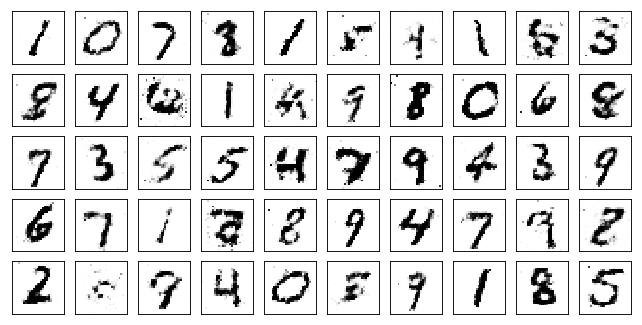

Test losses. G: 1.0400, D: 0.5530
Train Epoch: 40 [0/50000 (0%)]	Losses G: 0.9940, D: 0.5711
Train Epoch: 40 [5000/50000 (10%)]	Losses G: 0.9132, D: 0.6221
Train Epoch: 40 [10000/50000 (20%)]	Losses G: 1.2169, D: 0.5666
Train Epoch: 40 [15000/50000 (30%)]	Losses G: 1.0985, D: 0.6032
Train Epoch: 40 [20000/50000 (40%)]	Losses G: 1.1808, D: 0.5555
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 0.8791, D: 0.6358
Train Epoch: 40 [30000/50000 (60%)]	Losses G: 0.9391, D: 0.6837
Train Epoch: 40 [35000/50000 (70%)]	Losses G: 1.3110, D: 0.5336
Train Epoch: 40 [40000/50000 (80%)]	Losses G: 1.2430, D: 0.5677
Train Epoch: 40 [45000/50000 (90%)]	Losses G: 0.9941, D: 0.5703
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 0.9549, D: 0.5708
target: tensor([4, 8, 5, 6, 8, 5, 0, 9, 8, 4, 1, 7, 5, 0, 5, 5, 6, 4, 8, 1, 4, 3, 1, 8,
        0, 9, 6, 9, 7, 8, 1, 8, 8, 9, 6, 1, 8, 9, 2, 6, 3, 6, 9, 5, 7, 8, 2, 1,
        4, 8])


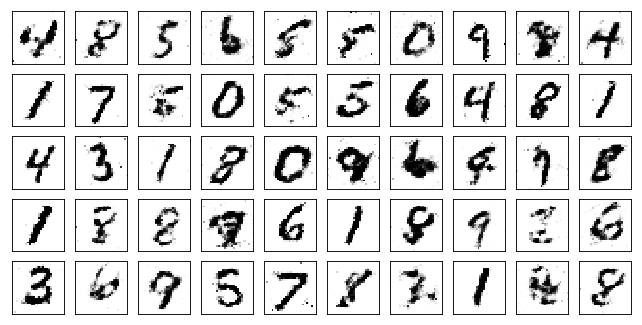

Test losses. G: 0.9766, D: 0.5316
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.1214, D: 0.5915
Train Epoch: 41 [5000/50000 (10%)]	Losses G: 0.9278, D: 0.5993
Train Epoch: 41 [10000/50000 (20%)]	Losses G: 1.1574, D: 0.6026
Train Epoch: 41 [15000/50000 (30%)]	Losses G: 0.9858, D: 0.6020
Train Epoch: 41 [20000/50000 (40%)]	Losses G: 1.0232, D: 0.6863
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.0129, D: 0.5573
Train Epoch: 41 [30000/50000 (60%)]	Losses G: 1.0446, D: 0.6464
Train Epoch: 41 [35000/50000 (70%)]	Losses G: 1.1011, D: 0.5606
Train Epoch: 41 [40000/50000 (80%)]	Losses G: 0.9291, D: 0.6086
Train Epoch: 41 [45000/50000 (90%)]	Losses G: 1.2979, D: 0.5398
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 0.8858, D: 0.5710
target: tensor([7, 7, 2, 5, 1, 2, 9, 9, 4, 6, 3, 7, 4, 7, 6, 3, 1, 2, 6, 1, 9, 1, 8, 0,
        7, 3, 7, 1, 6, 4, 4, 2, 3, 9, 6, 8, 9, 4, 1, 9, 9, 1, 7, 8, 6, 4, 1, 6,
        9, 5])


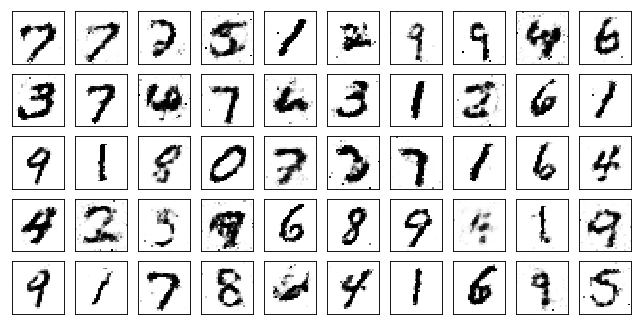

Test losses. G: 0.9219, D: 0.5689
Train Epoch: 42 [0/50000 (0%)]	Losses G: 0.9250, D: 0.5575
Train Epoch: 42 [5000/50000 (10%)]	Losses G: 1.0803, D: 0.6742
Train Epoch: 42 [10000/50000 (20%)]	Losses G: 1.0006, D: 0.6148
Train Epoch: 42 [15000/50000 (30%)]	Losses G: 1.0588, D: 0.6074
Train Epoch: 42 [20000/50000 (40%)]	Losses G: 1.1104, D: 0.5874
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 1.1463, D: 0.6036
Train Epoch: 42 [30000/50000 (60%)]	Losses G: 0.9447, D: 0.6245
Train Epoch: 42 [35000/50000 (70%)]	Losses G: 0.9565, D: 0.5896
Train Epoch: 42 [40000/50000 (80%)]	Losses G: 1.1559, D: 0.6042
Train Epoch: 42 [45000/50000 (90%)]	Losses G: 1.1809, D: 0.5362
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 0.9983, D: 0.6318
target: tensor([1, 7, 5, 3, 4, 6, 4, 0, 9, 0, 7, 8, 7, 0, 4, 1, 4, 1, 9, 2, 3, 9, 2, 4,
        3, 2, 3, 0, 8, 7, 5, 0, 1, 0, 8, 8, 8, 4, 5, 5, 2, 2, 4, 2, 1, 6, 0, 7,
        3, 0])


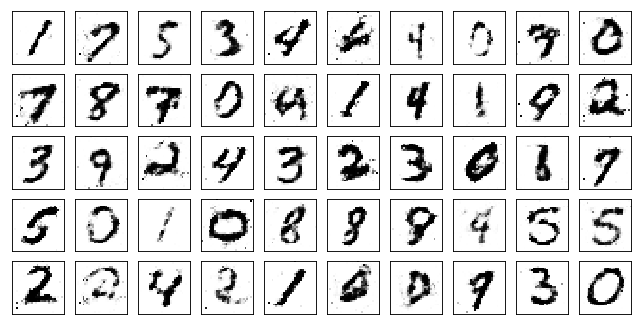

Test losses. G: 1.0324, D: 0.5649
Train Epoch: 43 [0/50000 (0%)]	Losses G: 1.1948, D: 0.6503
Train Epoch: 43 [5000/50000 (10%)]	Losses G: 1.0032, D: 0.6838
Train Epoch: 43 [10000/50000 (20%)]	Losses G: 1.3288, D: 0.5749
Train Epoch: 43 [15000/50000 (30%)]	Losses G: 0.8855, D: 0.5595
Train Epoch: 43 [20000/50000 (40%)]	Losses G: 1.0557, D: 0.5801
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 1.1601, D: 0.6068
Train Epoch: 43 [30000/50000 (60%)]	Losses G: 0.9702, D: 0.6739
Train Epoch: 43 [35000/50000 (70%)]	Losses G: 1.1443, D: 0.5644
Train Epoch: 43 [40000/50000 (80%)]	Losses G: 0.9828, D: 0.5747
Train Epoch: 43 [45000/50000 (90%)]	Losses G: 0.8424, D: 0.5435
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 0.8725, D: 0.6302
target: tensor([1, 8, 1, 4, 7, 5, 2, 8, 0, 0, 9, 7, 2, 6, 5, 6, 7, 5, 0, 7, 8, 0, 0, 1,
        7, 2, 2, 3, 8, 9, 0, 7, 5, 2, 1, 5, 4, 5, 3, 6, 6, 9, 7, 0, 2, 4, 4, 2,
        7, 7])


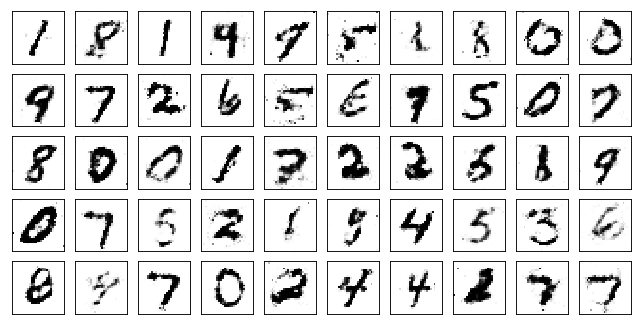

Test losses. G: 0.8517, D: 0.5929
Train Epoch: 44 [0/50000 (0%)]	Losses G: 0.8574, D: 0.6111
Train Epoch: 44 [5000/50000 (10%)]	Losses G: 1.0060, D: 0.5102
Train Epoch: 44 [10000/50000 (20%)]	Losses G: 1.1598, D: 0.5905
Train Epoch: 44 [15000/50000 (30%)]	Losses G: 1.0346, D: 0.5577
Train Epoch: 44 [20000/50000 (40%)]	Losses G: 1.0675, D: 0.6060
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 0.9330, D: 0.5383
Train Epoch: 44 [30000/50000 (60%)]	Losses G: 0.9254, D: 0.6154
Train Epoch: 44 [35000/50000 (70%)]	Losses G: 1.0840, D: 0.6357
Train Epoch: 44 [40000/50000 (80%)]	Losses G: 0.8341, D: 0.6365
Train Epoch: 44 [45000/50000 (90%)]	Losses G: 1.0801, D: 0.5497
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 0.9224, D: 0.6351
target: tensor([9, 6, 5, 8, 1, 8, 1, 8, 7, 5, 4, 9, 2, 9, 1, 8, 1, 9, 6, 6, 1, 3, 7, 5,
        6, 3, 5, 7, 2, 6, 8, 8, 7, 3, 8, 7, 6, 1, 5, 7, 0, 1, 2, 1, 4, 0, 5, 6,
        0, 3])


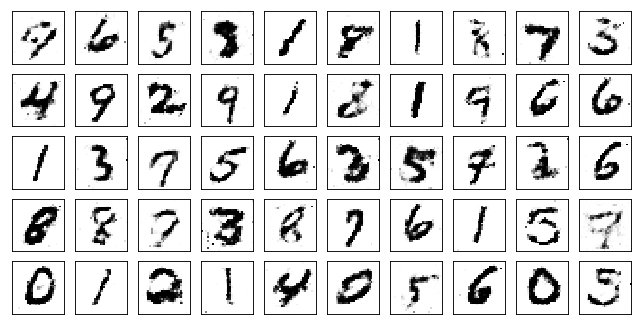

Test losses. G: 0.8860, D: 0.6034
Train Epoch: 45 [0/50000 (0%)]	Losses G: 1.0481, D: 0.6323
Train Epoch: 45 [5000/50000 (10%)]	Losses G: 0.9751, D: 0.5137
Train Epoch: 45 [10000/50000 (20%)]	Losses G: 1.0800, D: 0.6299
Train Epoch: 45 [15000/50000 (30%)]	Losses G: 1.2188, D: 0.5505
Train Epoch: 45 [20000/50000 (40%)]	Losses G: 0.9764, D: 0.6163
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 0.7766, D: 0.7166
Train Epoch: 45 [30000/50000 (60%)]	Losses G: 1.0833, D: 0.5447
Train Epoch: 45 [35000/50000 (70%)]	Losses G: 1.0267, D: 0.6595
Train Epoch: 45 [40000/50000 (80%)]	Losses G: 0.8803, D: 0.6504
Train Epoch: 45 [45000/50000 (90%)]	Losses G: 1.1436, D: 0.5727
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 1.1129, D: 0.6426
target: tensor([7, 0, 7, 0, 9, 5, 8, 0, 3, 8, 9, 3, 5, 1, 2, 2, 0, 8, 0, 3, 9, 8, 9, 1,
        0, 1, 6, 7, 3, 4, 3, 8, 8, 7, 3, 2, 3, 3, 6, 4, 5, 4, 4, 1, 4, 2, 0, 8,
        8, 8])


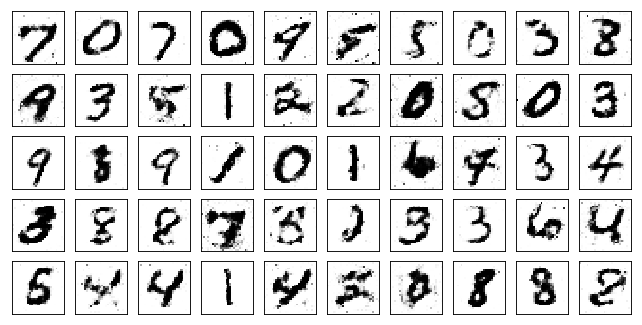

Test losses. G: 1.0040, D: 0.5882
Train Epoch: 46 [0/50000 (0%)]	Losses G: 1.0291, D: 0.7185
Train Epoch: 46 [5000/50000 (10%)]	Losses G: 0.8906, D: 0.6108
Train Epoch: 46 [10000/50000 (20%)]	Losses G: 1.0836, D: 0.6282
Train Epoch: 46 [15000/50000 (30%)]	Losses G: 0.8494, D: 0.6428
Train Epoch: 46 [20000/50000 (40%)]	Losses G: 0.9093, D: 0.6783
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.1601, D: 0.6149
Train Epoch: 46 [30000/50000 (60%)]	Losses G: 0.9766, D: 0.5520
Train Epoch: 46 [35000/50000 (70%)]	Losses G: 0.9926, D: 0.6029
Train Epoch: 46 [40000/50000 (80%)]	Losses G: 0.9839, D: 0.6548
Train Epoch: 46 [45000/50000 (90%)]	Losses G: 1.1640, D: 0.5186
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 0.9516, D: 0.6340
target: tensor([6, 1, 0, 8, 2, 1, 8, 6, 8, 7, 1, 3, 6, 5, 4, 9, 4, 3, 6, 6, 7, 3, 2, 1,
        5, 7, 6, 9, 2, 2, 3, 4, 6, 8, 6, 3, 9, 7, 1, 7, 2, 3, 9, 4, 1, 0, 8, 0,
        3, 5])


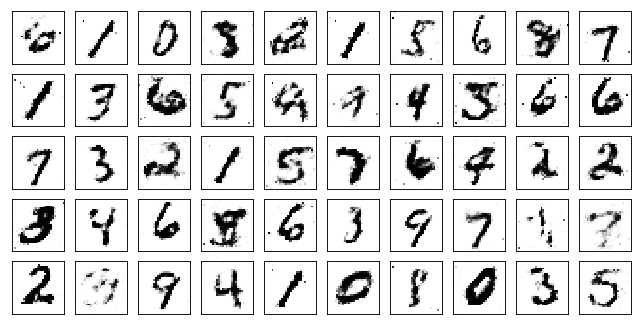

Test losses. G: 0.9038, D: 0.6021
Train Epoch: 47 [0/50000 (0%)]	Losses G: 0.8965, D: 0.6098
Train Epoch: 47 [5000/50000 (10%)]	Losses G: 0.9701, D: 0.5914
Train Epoch: 47 [10000/50000 (20%)]	Losses G: 0.9704, D: 0.5950
Train Epoch: 47 [15000/50000 (30%)]	Losses G: 0.9102, D: 0.5883
Train Epoch: 47 [20000/50000 (40%)]	Losses G: 0.9814, D: 0.5554
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 0.8092, D: 0.6209
Train Epoch: 47 [30000/50000 (60%)]	Losses G: 1.0979, D: 0.6608
Train Epoch: 47 [35000/50000 (70%)]	Losses G: 1.3366, D: 0.6327
Train Epoch: 47 [40000/50000 (80%)]	Losses G: 0.7187, D: 0.6430
Train Epoch: 47 [45000/50000 (90%)]	Losses G: 1.2272, D: 0.6124
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 1.0824, D: 0.5949
target: tensor([4, 4, 6, 0, 0, 0, 0, 1, 2, 0, 3, 9, 4, 7, 8, 0, 2, 7, 1, 7, 1, 7, 2, 0,
        6, 2, 3, 1, 2, 2, 8, 2, 3, 5, 9, 9, 0, 5, 9, 8, 4, 5, 6, 9, 7, 0, 1, 7,
        0, 7])


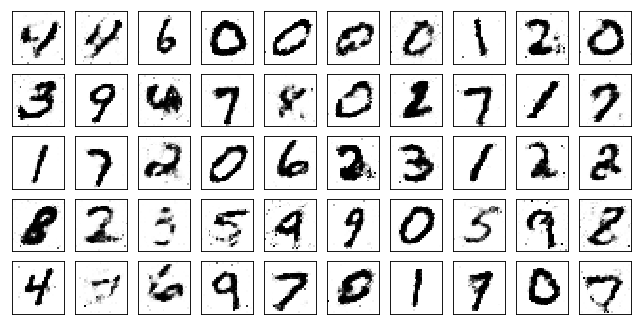

Test losses. G: 1.0274, D: 0.5487
Train Epoch: 48 [0/50000 (0%)]	Losses G: 1.0210, D: 0.6050
Train Epoch: 48 [5000/50000 (10%)]	Losses G: 0.8857, D: 0.5648
Train Epoch: 48 [10000/50000 (20%)]	Losses G: 0.8886, D: 0.6108
Train Epoch: 48 [15000/50000 (30%)]	Losses G: 1.1425, D: 0.5686
Train Epoch: 48 [20000/50000 (40%)]	Losses G: 0.7427, D: 0.6886
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 1.1613, D: 0.6801
Train Epoch: 48 [30000/50000 (60%)]	Losses G: 0.8527, D: 0.5644
Train Epoch: 48 [35000/50000 (70%)]	Losses G: 0.8404, D: 0.6485
Train Epoch: 48 [40000/50000 (80%)]	Losses G: 0.9492, D: 0.5977
Train Epoch: 48 [45000/50000 (90%)]	Losses G: 0.9964, D: 0.6210
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 0.8925, D: 0.5684
target: tensor([2, 9, 9, 9, 0, 8, 1, 2, 2, 2, 2, 9, 0, 4, 8, 9, 9, 2, 2, 4, 7, 7, 7, 0,
        1, 9, 2, 1, 7, 7, 3, 3, 4, 9, 1, 2, 5, 4, 5, 0, 0, 9, 7, 2, 2, 1, 2, 1,
        3, 6])


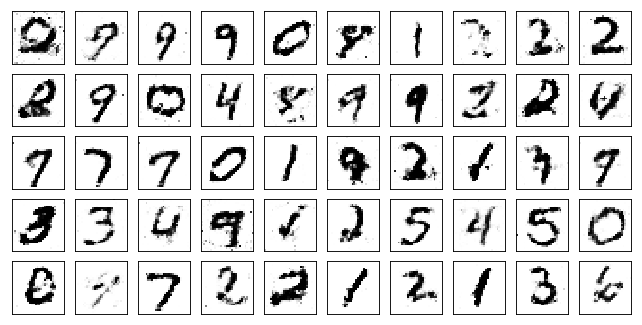

Test losses. G: 1.0035, D: 0.5584
Train Epoch: 49 [0/50000 (0%)]	Losses G: 0.9661, D: 0.5712
Train Epoch: 49 [5000/50000 (10%)]	Losses G: 1.0036, D: 0.6160
Train Epoch: 49 [10000/50000 (20%)]	Losses G: 0.9939, D: 0.5433
Train Epoch: 49 [15000/50000 (30%)]	Losses G: 1.0278, D: 0.5433
Train Epoch: 49 [20000/50000 (40%)]	Losses G: 0.8625, D: 0.5989
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 0.9718, D: 0.6850
Train Epoch: 49 [30000/50000 (60%)]	Losses G: 1.0033, D: 0.6118
Train Epoch: 49 [35000/50000 (70%)]	Losses G: 1.0036, D: 0.5437
Train Epoch: 49 [40000/50000 (80%)]	Losses G: 1.2006, D: 0.5972
Train Epoch: 49 [45000/50000 (90%)]	Losses G: 1.1591, D: 0.6432
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 1.0193, D: 0.6499
target: tensor([6, 3, 7, 1, 6, 6, 9, 8, 4, 5, 9, 7, 1, 5, 2, 6, 7, 0, 6, 1, 7, 1, 5, 3,
        5, 4, 1, 1, 2, 1, 8, 5, 3, 8, 6, 6, 7, 1, 6, 5, 9, 4, 4, 6, 0, 9, 4, 4,
        6, 3])


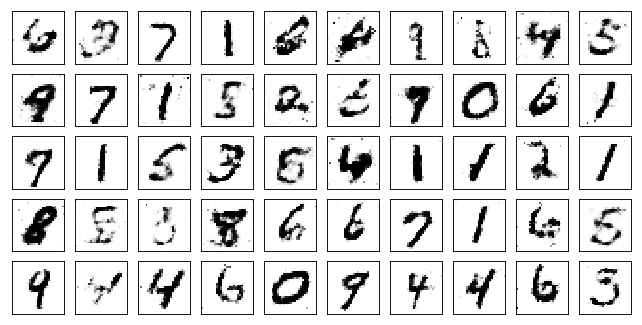

Test losses. G: 1.0630, D: 0.5810
Train Epoch: 50 [0/50000 (0%)]	Losses G: 0.9435, D: 0.6837
Train Epoch: 50 [5000/50000 (10%)]	Losses G: 1.0559, D: 0.5415
Train Epoch: 50 [10000/50000 (20%)]	Losses G: 0.8581, D: 0.6811
Train Epoch: 50 [15000/50000 (30%)]	Losses G: 1.2400, D: 0.5443
Train Epoch: 50 [20000/50000 (40%)]	Losses G: 0.7816, D: 0.5978
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 1.0159, D: 0.5080
Train Epoch: 50 [30000/50000 (60%)]	Losses G: 0.9415, D: 0.6287
Train Epoch: 50 [35000/50000 (70%)]	Losses G: 0.8050, D: 0.6803
Train Epoch: 50 [40000/50000 (80%)]	Losses G: 0.9164, D: 0.6067
Train Epoch: 50 [45000/50000 (90%)]	Losses G: 0.9716, D: 0.6500
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 1.1509, D: 0.5500
target: tensor([7, 3, 8, 5, 8, 1, 1, 5, 0, 1, 5, 9, 0, 8, 2, 7, 2, 4, 1, 6, 3, 2, 4, 4,
        3, 4, 7, 1, 2, 3, 8, 4, 1, 0, 8, 8, 4, 6, 9, 3, 7, 3, 7, 2, 7, 7, 1, 8,
        4, 0])


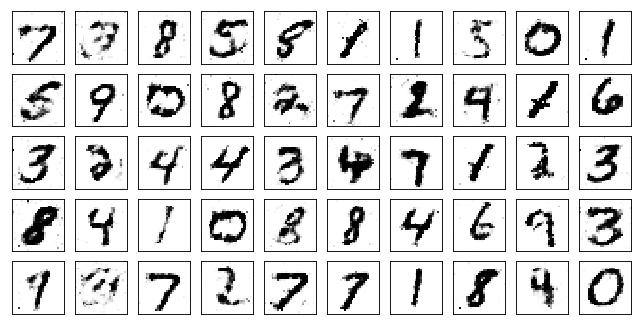

Test losses. G: 1.0678, D: 0.5244
Train Epoch: 51 [0/50000 (0%)]	Losses G: 1.1557, D: 0.5606
Train Epoch: 51 [5000/50000 (10%)]	Losses G: 1.0397, D: 0.5783
Train Epoch: 51 [10000/50000 (20%)]	Losses G: 1.0118, D: 0.6072
Train Epoch: 51 [15000/50000 (30%)]	Losses G: 0.9854, D: 0.6369
Train Epoch: 51 [20000/50000 (40%)]	Losses G: 0.9952, D: 0.6694
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 0.8219, D: 0.5269
Train Epoch: 51 [30000/50000 (60%)]	Losses G: 0.8594, D: 0.5759
Train Epoch: 51 [35000/50000 (70%)]	Losses G: 0.8077, D: 0.6683


In [ ]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)